# LEO Satellite Pass Prediction Error Correction

In this notebook we will be developing a machine learning model to correct errors in the satellite's fundamental orbital state prediction, which is the root cause of inaccuracies in calculated pass times (AOS/LOS) for ground stations in LEO satellite pass times (AOS and LOS) caused by space weather and orbital disturbances. By training models on orbital data and solar activity, it improves the timing accuracy for ground station communications. 

### Project Setup


In [499]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import uniform, randint

from skyfield.api import load, EarthSatellite
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb


In [403]:
tle_filename = 'data/landsat8_tle_history.txt'


## 1. Data Loading and Quality Check

Here, we load the raw datasets and perform the initial quality check steps as outlined in the main report.

For the satellite data we will have the following features:

- tle_date - UTC date of TLE generation
- mean_motion - How many orbits the satellite makes around the earth in a day
- eccentricity - Shape of orbit; 0 - Circle  1 - Ellipse


![eccentricity](https://assets.science.nasa.gov/content/dam/science/esd/eo/content-feature/orbitscatalog/images/ellipse_diagram.png)

- inclination - Angle (degrees) between the satellite and the Earth's equator

![inclination angle](https://assets.science.nasa.gov/content/dam/science/esd/eo/content-feature/orbitscatalog/images/orbital_inclination.png)

- bstar - Coefficient to represent how much the satellite is affected by atmospheric drag


For space weather data we have the following features:

- yy , mm, dd - Date format for year, month and day
- BSRN - Bartels Solar Rotation Number - count of the number of the Sun's rotations
- ND - Number of days for current BSRN ; (1 to 27)

- Kp (1-8) - Planetary K-index - Measure of global geomagnetic activity (0-90) for a 3 hour window on a log-scale x10 - i.e. Measure of the disruption to Earth's magnetic field caused by solar wind.

- Ap (1-8) - Planetary A-index - Measure of global geomagnetic activity on a linear scale over a 3 hour window (nT - nanoTeslas)

- Cp - Planetary Character Figure - A qualitative estimate of the overall geomagnetic activity for a given day.

- C9 - Index relating to the magnitude of Ap value for that day

- ISN - International Sunspot Number - A measure of the number of sunspots present on the surface of the Sun

- F10.7 - Measure of the intensity of solar radio emissions at a wavelength of 10.7 centimeters; it is used due to being higly corellated to solar activity

- Ctr81 - 81-day average of the F10.7 solar flux centred on the given day i.e. uses 40 day previous and 40 days in the future

- Lst81 - 81-day average of the F10.7 solar flux using the given day and the previous 80 days of data

The F10.7, Ctrl81 & Lst81 values have observed and adjusted values which represent raw measurement of solar radio flux taken here on Earth and the same measurement corrected to a standard distance from the Sun; the disparity is due to the Earth's orbit being elliplical so our distance from the Sun changes throughout the year.

### 1.1. Data Loading

Before we could analyse the space weather data, some initial preparation was necessary. The raw data file contained header information and future-dated entries that were not relevant to our historical analysis. We spliced the dataset to isolate the specific time period we needed, effectively removing this extra information.

Due to the file's multi-level column headers, we also had to manually define the column names during the loading process. This ensured the data was parsed correctly into a structured DataFrame.

Separately, to work with the satellite's orbital data, we used the Skyfield Python library. Specifically, its load method was used to read the Two-Line Element (TLE) files. This conveniently creates Earth-orbiting satellite objects, allowing us to easily access and compute features like position, velocity, and pass times over the ground station.

In [404]:
# Load Satellite TLE Data

satellites = load.tle_file(tle_filename) # The load function reads the TLE file and returns a list of EarthSatellite objects.

tle_data = []
for sat in satellites:
    tle_data.append({
        'tle_date': sat.epoch.utc_datetime(), # UTC date of the TLE generation
        'mean_motion': sat.model.mm,      # Orbits per day
        'eccentricity': sat.model.ecco,   # Eccentricity of the orbit
        'inclination': sat.model.inclo,   # Stored in degrees
        'bstar': sat.model.bstar,          # The B* drag term
    })


# Convert the list of dictionaries into a clean pandas DataFrame.
tle_df = pd.DataFrame(tle_data)

print(tle_df.shape)

tle_df.head()

(14991, 5)


,tle_date,mean_motion,eccentricity,inclination,bstar
0,2013-02-11 19:01:55.474762+00:00,-5.231754,0.001209,1.714704,0.0
1,2013-02-11 19:01:55.474762+00:00,-5.231754,0.001209,1.714704,0.0
2,2013-02-11 20:40:17.684265+00:00,-5.117724,0.001129,1.714709,0.0
3,2013-02-11 20:40:18.187988+00:00,-5.117208,0.001129,1.714709,0.0
4,2013-02-12 01:35:19.667908+00:00,-5.107807,0.001137,1.714704,0.0


In [405]:
# Load Space Weather Data

# Set display options for pandas DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

# This value is used to determine how many rows to read from the space weather data file that are of interest.
nrows = int(np.ceil((49549-35)/2))


col = [
	'year', 'month', 'day', 'BSRN', 'ND',
	'Kp1', 'Kp2', 'Kp3', 'Kp4', 'Kp5', 'Kp6', 'Kp7', 'Kp8', 'Sum',
	'Ap1', 'Ap2', 'Ap3', 'Ap4', 'Ap5', 'Ap6', 'Ap7', 'Ap8', 'Avg',
	'Cp', 'C9', 'ISN', 'F10.7_adj', 'Q', 'Ctr81_adj', 'Lst81_adj', 'F10.7_obs', 'Ctr81_obs', 'Lst81_obs'
]
space_weather_df = pd.read_csv(
	'data/space_weather_data.txt',
	skiprows=35,
	sep='\s+',
	header=None,
	names=col
)
space_weather_df = space_weather_df.iloc[:nrows, :]
print(space_weather_df.shape)
space_weather_df.tail()

(24757, 33)


<>:20: SyntaxWarning:

invalid escape sequence '\s'

<>:20: SyntaxWarning:

invalid escape sequence '\s'

C:\Users\kashl\AppData\Local\Temp\ipykernel_23832\3637323386.py:20: SyntaxWarning:

invalid escape sequence '\s'

C:\Users\kashl\AppData\Local\Temp\ipykernel_23832\3637323386.py:17: DtypeWarning:

Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.



,year,month,day,BSRN,ND,Kp1,Kp2,Kp3,Kp4,Kp5,Kp6,Kp7,Kp8,Sum,Ap1,Ap2,Ap3,Ap4,Ap5,Ap6,Ap7,Ap8,Avg,Cp,C9,ISN,F10.7_adj,Q,Ctr81_adj,Lst81_adj,F10.7_obs,Ctr81_obs,Lst81_obs
24752,2025,07,9.0,2617.0,13.0,27.0,23.0,13.0,13.0,17.0,17.0,13.0,13.0,137.0,12.0,9.0,5.0,5.0,6.0,6.0,5.0,5.0,7.0,0.3,1.0,88.0,124.3,0.0,127.8,138.8,120.2,123.9,135.4
24753,2025,07,10.0,2617.0,14.0,7.0,10.0,10.0,3.0,0.0,7.0,3.0,0.0,40.0,3.0,4.0,4.0,2.0,0.0,3.0,2.0,0.0,2.0,0.0,0.0,80.0,133.8,0.0,127.3,138.5,129.5,123.4,135.1
24754,2025,07,11.0,2617.0,15.0,17.0,27.0,27.0,40.0,30.0,20.0,43.0,37.0,240.0,6.0,12.0,12.0,27.0,15.0,7.0,32.0,22.0,17.0,0.9,4.0,97.0,136.8,0.0,126.7,138.2,132.4,122.8,134.7
24755,2025,07,12.0,2617.0,16.0,27.0,27.0,30.0,33.0,27.0,17.0,23.0,27.0,210.0,12.0,12.0,15.0,18.0,12.0,6.0,9.0,12.0,12.0,0.7,3.0,115.0,143.3,0.0,126.2,137.9,138.7,122.4,134.4
24756,2025,07,13.0,2617.0,17.0,40.0,43.0,33.0,33.0,40.0,30.0,33.0,30.0,283.0,27.0,32.0,18.0,18.0,27.0,15.0,18.0,15.0,21.0,1.1,5.0,129.0,132.4,0.0,126.5,137.4,128.2,122.8,133.9


### 1.2. Data Quality Check

A quick check on the data quality shows it's in excellent condition. We're fortunate to have a dataset with a noticeable lack of errors or missing (NaN) values. This high level of integrity is what you'd typically expect from professional telemetry and space weather sources, giving us a solid and reliable foundation for the analysis.

We do a small amount of correcting for the data type of the Month and Year Values due to some being integers and others being strings

In [406]:
tle_df.isna().sum()

tle_date        0
mean_motion     0
eccentricity    0
inclination     0
bstar           0
dtype: int64

In [407]:
space_weather_df.isna().sum()

year         0
month        0
day          0
BSRN         0
ND           0
Kp1          0
Kp2          0
Kp3          0
Kp4          0
Kp5          0
Kp6          0
Kp7          0
Kp8          0
Sum          0
Ap1          0
Ap2          0
Ap3          0
Ap4          0
Ap5          0
Ap6          0
Ap7          0
Ap8          0
Avg          0
Cp           0
C9           0
ISN          0
F10.7_adj    0
Q            0
Ctr81_adj    0
Lst81_adj    0
F10.7_obs    0
Ctr81_obs    0
Lst81_obs    0
dtype: int64

In [408]:
# Remove duplicate TLE lines (by tle_date) in tle_df
print("Before removing duplicates:", tle_df.shape)
tle_df = tle_df.drop_duplicates(subset=['tle_date']).reset_index(drop=True)
print("After removing duplicates:", tle_df.shape)


# Remove duplicate rows in space_weather_df (by year, month, day)
print("Before removing duplicates:", space_weather_df.shape)
space_weather_df = space_weather_df.drop_duplicates(subset=['year', 'month', 'day']).reset_index(drop=True)
print("After removing duplicates:", space_weather_df.shape)

Before removing duplicates: (14991, 5)
After removing duplicates: (13340, 5)
Before removing duplicates: (24757, 33)
After removing duplicates: (24757, 33)


In [409]:
space_weather_df.dtypes

year          object
month         object
day          float64
BSRN         float64
ND           float64
Kp1          float64
Kp2          float64
Kp3          float64
Kp4          float64
Kp5          float64
Kp6          float64
Kp7          float64
Kp8          float64
Sum          float64
Ap1          float64
Ap2          float64
Ap3          float64
Ap4          float64
Ap5          float64
Ap6          float64
Ap7          float64
Ap8          float64
Avg          float64
Cp           float64
C9           float64
ISN          float64
F10.7_adj    float64
Q            float64
Ctr81_adj    float64
Lst81_adj    float64
F10.7_obs    float64
Ctr81_obs    float64
Lst81_obs    float64
dtype: object

In [410]:
print("Unique Years in Space Weather Data:")
print(space_weather_df['year'].unique())

print("\nUnique Months in Space Weather Data:")
print(space_weather_df['month'].unique())

space_weather_df['year'] = space_weather_df['year'].astype(int)
space_weather_df['month'] = space_weather_df['month'].astype(int)

Unique Years in Space Weather Data:
[1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970
 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998
 1999 2000 2001 2002 '2002' '2003' '2004' '2005' '2006' '2007' '2008'
 '2009' '2010' '2011' '2012' '2013' '2014' '2015' '2016' '2017' '2018'
 '2019' '2020' '2021' '2022' '2023' '2024' '2025']

Unique Months in Space Weather Data:
[10 11 12 1 2 3 4 5 6 7 8 9 '08' '09' '10' '11' '12' '01' '02' '03' '04'
 '05' '06' '07']


In [411]:
space_weather_df.dtypes

year           int64
month          int64
day          float64
BSRN         float64
ND           float64
Kp1          float64
Kp2          float64
Kp3          float64
Kp4          float64
Kp5          float64
Kp6          float64
Kp7          float64
Kp8          float64
Sum          float64
Ap1          float64
Ap2          float64
Ap3          float64
Ap4          float64
Ap5          float64
Ap6          float64
Ap7          float64
Ap8          float64
Avg          float64
Cp           float64
C9           float64
ISN          float64
F10.7_adj    float64
Q            float64
Ctr81_adj    float64
Lst81_adj    float64
F10.7_obs    float64
Ctr81_obs    float64
Lst81_obs    float64
dtype: object

## 2. Exploratory Data Analysis (EDA)

With our data cleaned and prepared, we can now move on to Exploratory Data Analysis (EDA). The goal here is to visually inspect the data to understand its underlying patterns, identify trends, and spot any interesting relationships between different space weather indicators.

We will be exploring and creating visuals for the following relationships:

-----------------------------------------------------------------------------------------------------------------
Space Weather dataset

-----------------------------------------------------------------------------------------------------------------

2.1. Correlation Analysis - Space Weather Data

2.2. Geo magnetic activity over time based on the daily AP average

2.3. Histogram of Geomagnetic Activity based on the daily AP average

2.4. Solar Flux Activity based on the F10.7 Adjusted

2.5. Box Plot of Geomagnetic Activity by Year based on the Ap Index

2.6. Overlayed Bar plot for Geomagnetic Activity by Year based on the Ap Index

2.7. Normalised Stacked Bar plot for Ap_avg by Year

2.8. Box Plot of F10.7_obs by Year

2.9. Overlayed Bar plot for F10.7_obs by Year

2.10. Normalised Stacked Bar plot for F10.7_obs by Year

2.11. Correlation between F10.7_adj and Ap_avg

-----------------------------------------------------------------------------------------------------------------
Landsat 8 TLE dataset

-----------------------------------------------------------------------------------------------------------------

2.12. Correlation Analysis - Space Weather Data

2.13. Time-series plot of Landsat 8 satellitle orbital elements

In [412]:
# Create a 'date' column from year, month, day columns
space_weather_df['date'] = pd.to_datetime(
	space_weather_df['year'].astype(str) + '-' +
	space_weather_df['month'].astype(str).str.zfill(2) + '-' +
	space_weather_df['day'].astype(int).astype(str).str.zfill(2)
)

### 2.1. Correlation Analysis - Space Weather Data

To prepare our features for modeling, we generated a Pearson correlation matrix. This is crucial for identifying multicollinearity which is a phenomenon where two or more predictor variables are highly correlated, which can destabilise our model into over valuing the predictive capability of certain features. The analysis revealed several important relationships.

The matrix shows a near-perfect correlation between the observed and adjusted values for the F10.7 solar flux. This is expected, as the adjusted value is simply the observed reading corrected for Earth's distance from the Sun. Including both would introduce severe multicollinearity. For our model, we must select only one of these features.

A critical finding is that the Ctr81 values, which represent the 81-day centered average, rely on future data points for their calculation. Using these would cause data leakage, as our model would be trained on information that wouldn't be available in a real-time prediction scenario. Therefore, these columns must be removed.

There is a strong positive correlation between the International Sunspot Number (ISN) and the F10.7 solar flux values. This makes physical sense, as sunspots are regions of high magnetic activity that directly contribute to the solar radio emissions measured by the F10.7 index. While expected, this relationship is another case of multicollinearity that needs to be addressed.

Finally, the strong correlation between the Ap and Kp indices is a direct result of their mathematical relationship, where the daily Ap index is derived from the 3-hourly Kp values. Since both indices essentially represent the same geomagnetic activity, including both would be redundant. We will need to choose the one that is most suitable for our model's time scale.

Performing this correlation analysis early in our EDA will allow us to efficiently choose the features we will further investigate and prevent us from perfoming relatively similar analysis. Here are some key takeaways from our correlation analysis that will shape our future decisions:

- As we have validated the direct relation between the Kp and Ap values we will only be looking at Ap values moving forward.

- Having both adjusted and observed solar flux features which are highly correlated we will move forward with only adjusted features due to our goal for this project being the effect from Earth we want to give the model a feature that represents the true, unpredictable activity of the sun. It's a clean signal of the primary cause of atmospheric heating. We can then give the model a separate, feature to learn the predictable orbital cycle of the Earth telling the model exactly where the Earth is in its orbit. By doing this, we are giving the model two clean, independent features:
one for the Sun's activity & one for the Earth's position.

- ND has no correlation with any value, this may be down to the way it has been recorded not taking into account the geometric symmetry of the what ND represents i.e. 1 and 27 would be very similar in rotational position than 1 and 10 .
Feature engineering may be useful to converting this value to a useful feature.

- Year, month & Day have very low correlation with anything else. We therefore will remove them as direct features and use them for feature engineering instead.

- We are including both the daily F10.7 solar flux and its 81-day average as features. The daily value provides the model with the most current conditions, while the average provides the historical trend. This allows the model to learn from the difference between the present and the past, which is a powerful signal of momentum in solar activity.

- A key finding from the correlation matrix is the very low linear correlation between the geomagnetic index (Ap_Avg) and the F10.7 solar flux. This is good, as it suggests they are capturing different, independent aspects of space weather.



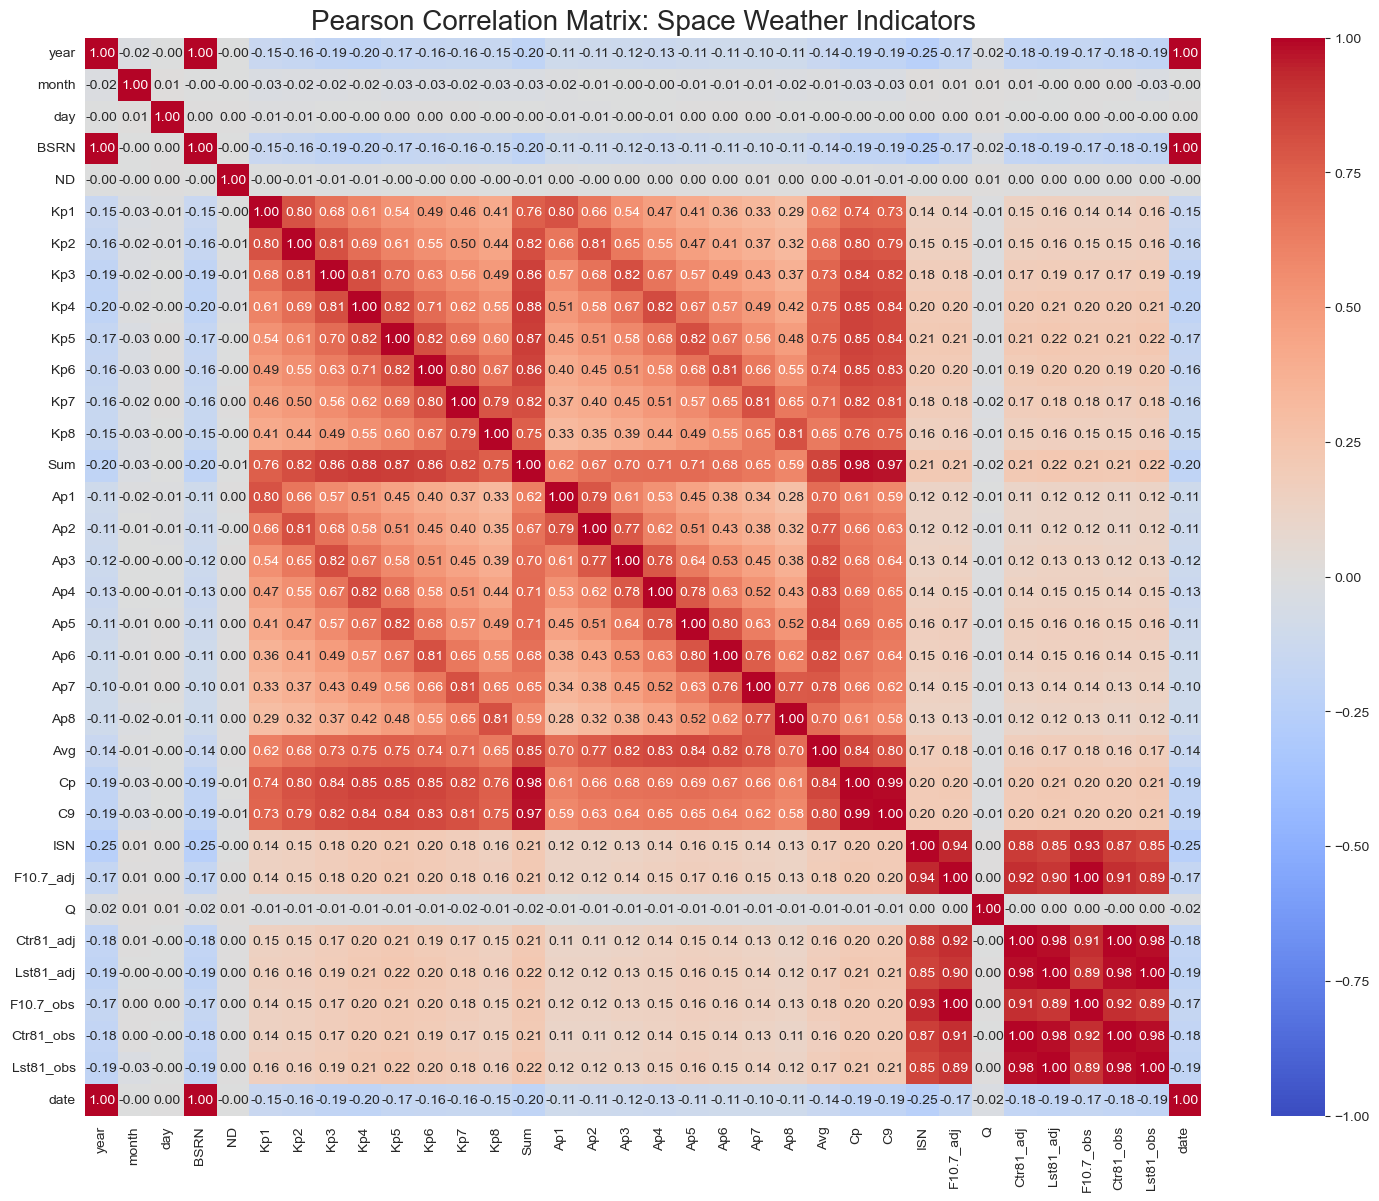

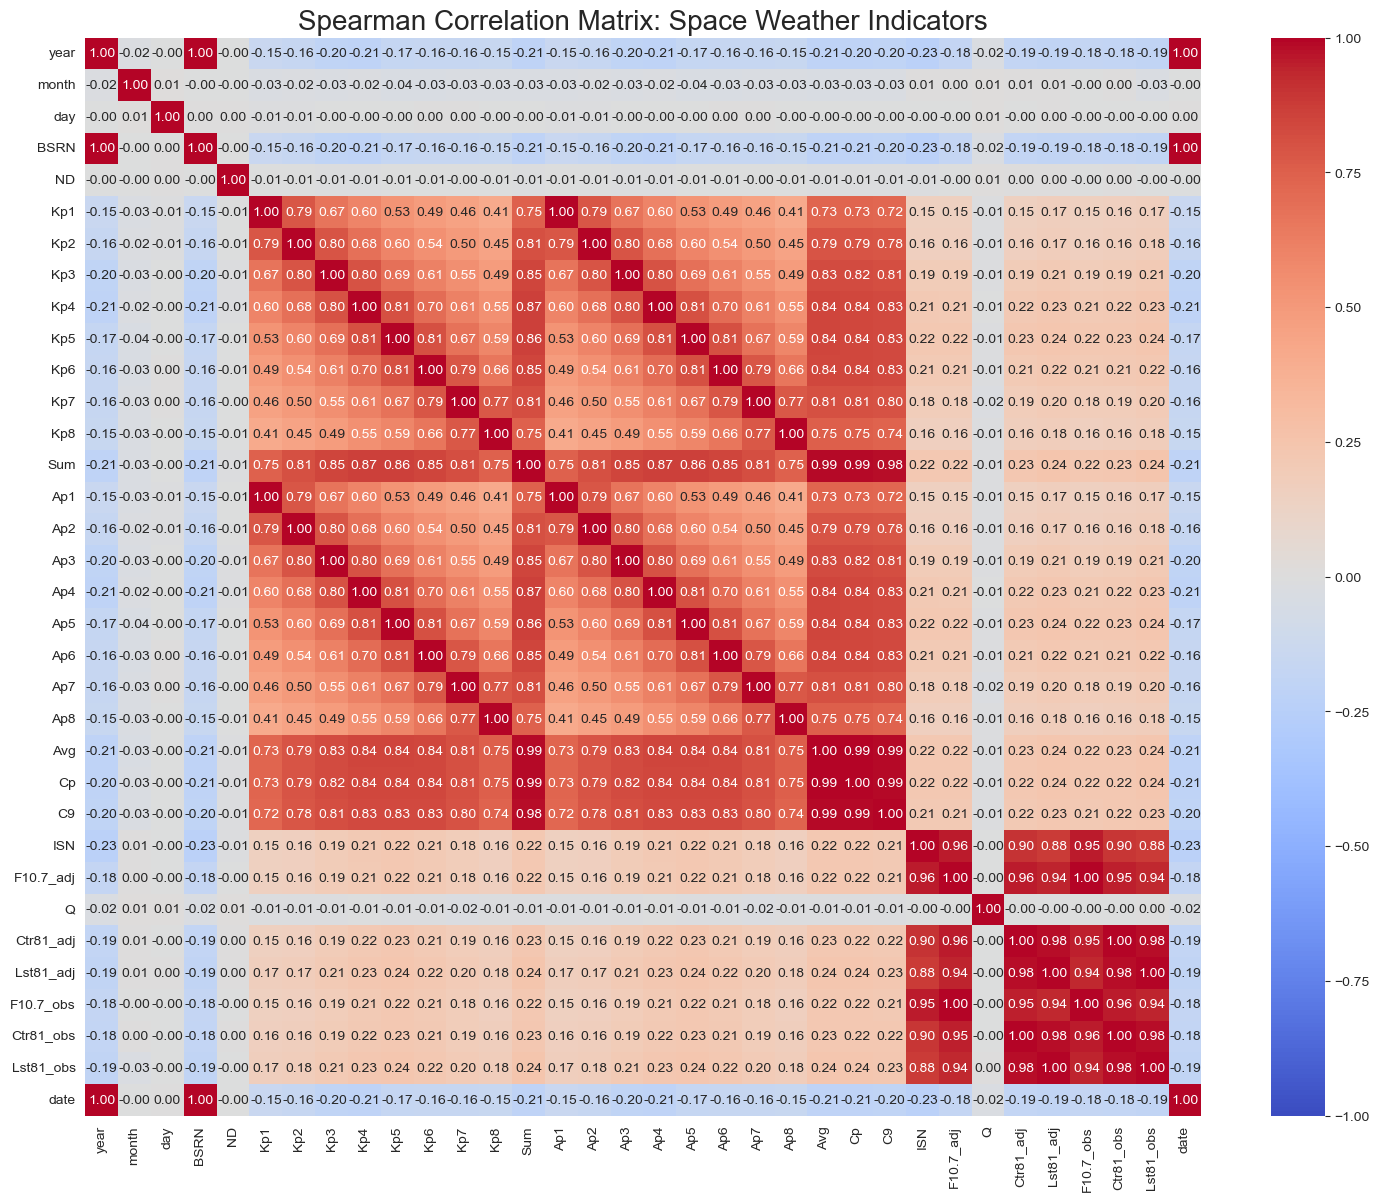

In [413]:
# The second matrix uses Spearman's rank correlation. This was done for a specific purpose: to visually confirm the known mathematical relationship between the Kp and Ap indices.
# Since the daily Ap index is derived directly from the 3-hourly Kp values through a logarithmic conversion, their relationship is monotonic but not perfectly linear.

# As expected, the Spearman matrix shows a much higher correlation between Kp and Ap than the Pearson matrix does. This doesn't pose a multicollinearity problem for our modeling;
# rather, it serves as a check, confirming that the known mathematical procedure to convert from one index to another is reflected in our data.


#### Pearson Correlation Matrix of Space Weather Features
pearson_corr = space_weather_df.corr(method='pearson')
plt.figure(figsize=(18, 14))
plt.title('Pearson Correlation Matrix: Space Weather Indicators', fontsize=20)
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.show()

#### Spearman Correlation Matrix of Space Weather Features

spearman_corr = space_weather_df.corr(method='spearman')
plt.figure(figsize=(18, 14))
plt.title('Spearman Correlation Matrix: Space Weather Indicators', fontsize=20)
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.show()


### 2.2. Geo magnetic activity over time based on the daily AP average

The geo magnetic activity over time based on the daily AP average shows a very interesting pattern. Focusing on the data from 1995 onwards, the cyclical nature of geomagnetic activity becomes exceptionally clear.
The plot shows a distinct period of low activity, a solar minimum, around 1996. Following this, the Ap values progressively increase to a solar maximum in the early 2000s before declining again.
This pattern repeats, leading into a prolonged minimum from 2008 to 2010. The subsequent cycle builds to another peak and then descends into the most recent minimum around 2020. 
This illustrates the last two full solar cycles showing the direct link between periods of lower solar activity and reduced geomagnetic activity.




### 2.3. Histogram of Geomagnetic Activity based on the daily AP average

The histogram provides a closer look at the distribution of these events. It shows that the vast majority of days have low to moderate geomagnetic activity, with the frequency of events decreasing sharply as the Ap index increases.
This indicates that while extreme geomagnetic storms (high Ap values) are relatively rare, they represent significant deviations from the norm that our predictive model should be able to account for.

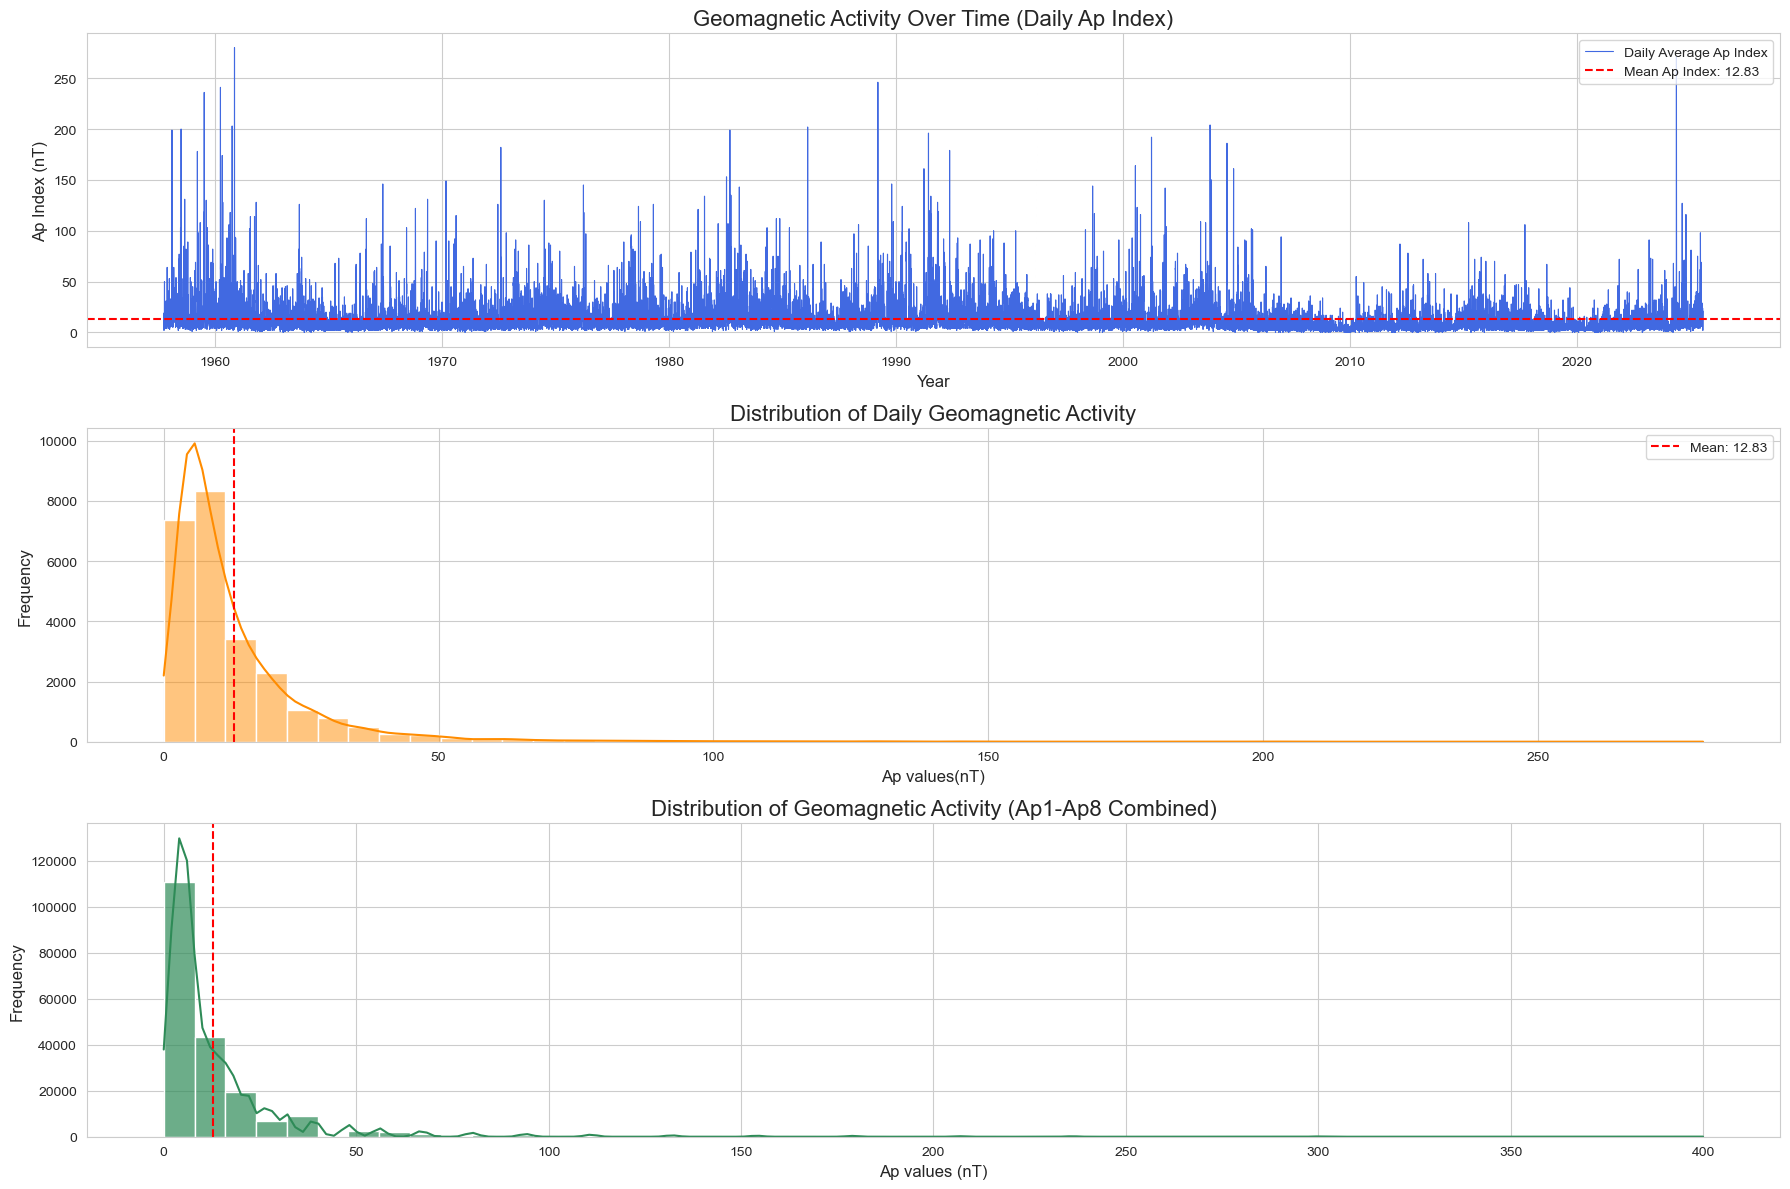

In [414]:

### Exploratory Data Analysis (EDA)

sns.set_style("whitegrid")
plt.figure(figsize=(18, 12))

# 2.1. Geo magnetic activity over time based on the daily AP average
plt.subplot(3, 1, 1)
plt.plot(space_weather_df['date'], space_weather_df['Avg'], label='Daily Average Ap Index', color='royalblue', linewidth=0.8)
plt.title('Geomagnetic Activity Over Time (Daily Ap Index)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Ap Index (nT)', fontsize=12)
plt.axhline(space_weather_df['Avg'].mean(), color='red', linestyle='dashed', linewidth=1.5, label='Mean Ap Index: {:.2f}'.format(space_weather_df['Avg'].mean()))
plt.legend()
#####################################################################################################################################################################

# 2.2. Histogram of Geomagnetic Activity based on the daily AP average
plt.subplot(3, 1, 2)
sns.histplot(space_weather_df['Avg'], bins=50, kde=True, color='darkorange')
plt.title('Distribution of Daily Geomagnetic Activity', fontsize=16)
plt.xlabel('Ap values(nT)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(space_weather_df['Avg'].mean(), color='red', linestyle='dashed', linewidth=1.5, label=f"Mean: {space_weather_df['Avg'].mean():.2f}")
plt.legend()

# Histogram of Geomagnetic Activity (All Ap1-Ap8 as one feature)

ap_cols = [f'Ap{i}' for i in range(1, 9)]
plt.subplot(3, 1, 3)
all_ap_values = pd.concat([space_weather_df[col] for col in ap_cols])
sns.histplot(all_ap_values, bins=50, color='seagreen', kde = True,  alpha=0.7)
plt.title('Distribution of Geomagnetic Activity (Ap1-Ap8 Combined)', fontsize=16)
plt.xlabel('Ap values (nT)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(all_ap_values.mean(), color='red', linestyle='dashed', linewidth=1.5, label=f"Mean: {all_ap_values.mean():.2f}")

plt.tight_layout()
plt.show()


### 2.4. Solar Flux Activity based on the F10.7 Adjusted

We will look at the F10.7 solar flux, which is a primary driver of space weather. Since higher F10.7 values lead to a denser upper atmosphere, understanding its trends is critical for our satellite drag model.

The time series of the F10.7 solar flux shows a clear ~11-year solar cycle. You can spot the regular spikes and dips that match up with solar maximums and minimums. Some of these cycles hit higher peaks than others, and you also get differences in shape—like the long, deep minimum around 2008–2009. Since solar activity directly affects upper atmosphere heating, picking up on these long-term patterns is key when we are trying to model things like atmospheric density or satellite drag.


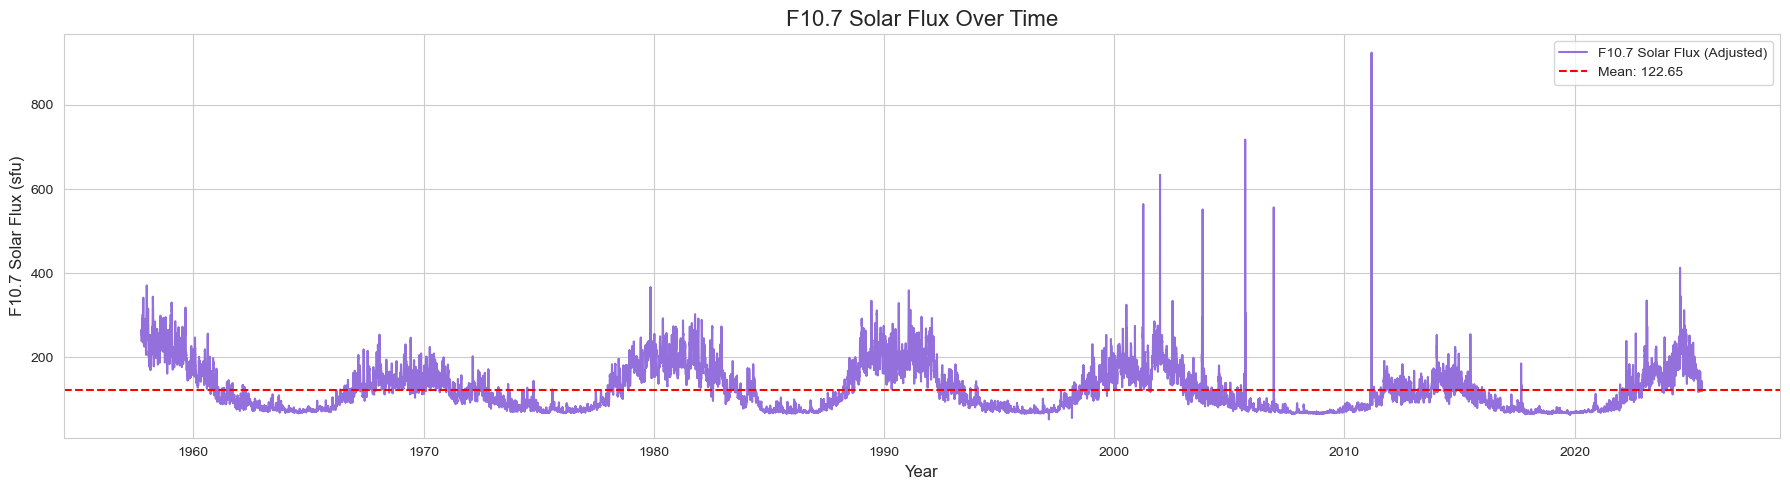

In [415]:
plt.figure(figsize=(18, 5))
sns.lineplot(
            data=space_weather_df,
            x='date',
            y='F10.7_adj',
            label='F10.7 Solar Flux (Adjusted)',
            color='mediumpurple'
            )

plt.title('F10.7 Solar Flux Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('F10.7 Solar Flux (sfu)', fontsize=12)
plt.axhline(space_weather_df['F10.7_adj'].mean(), color='red', linestyle='dashed', linewidth=1.5, label=f"Mean: {space_weather_df['F10.7_adj'].mean():.2f}")
plt.legend()    
plt.tight_layout()
plt.show()

### 2.5. Box Plot of Geomagnetic Activity by Year based on the Ap Index

The plot shows that while the median Ap index stays low each year there are frequent outliers as short bursts of geomagnetic activity, this confirms that the Ap Avg effectively captures short-term energy spikes. The recurring pattern also aligns with the 11-year solar cycle.

### 2.6. Overlayed Bar plot for Geomagnetic Activity by Year based on the Ap Index

### 2.7.  Normalised Stacked Bar plot for Ap_avg by Year

This plot normalises geomagnetic activity by year to highlight the proportion of calm days (IQR), moderately active days, and outlier storm events. While major geomagnetic storms are relatively rare, their presence is consistent across all years, which reinforces their significance.

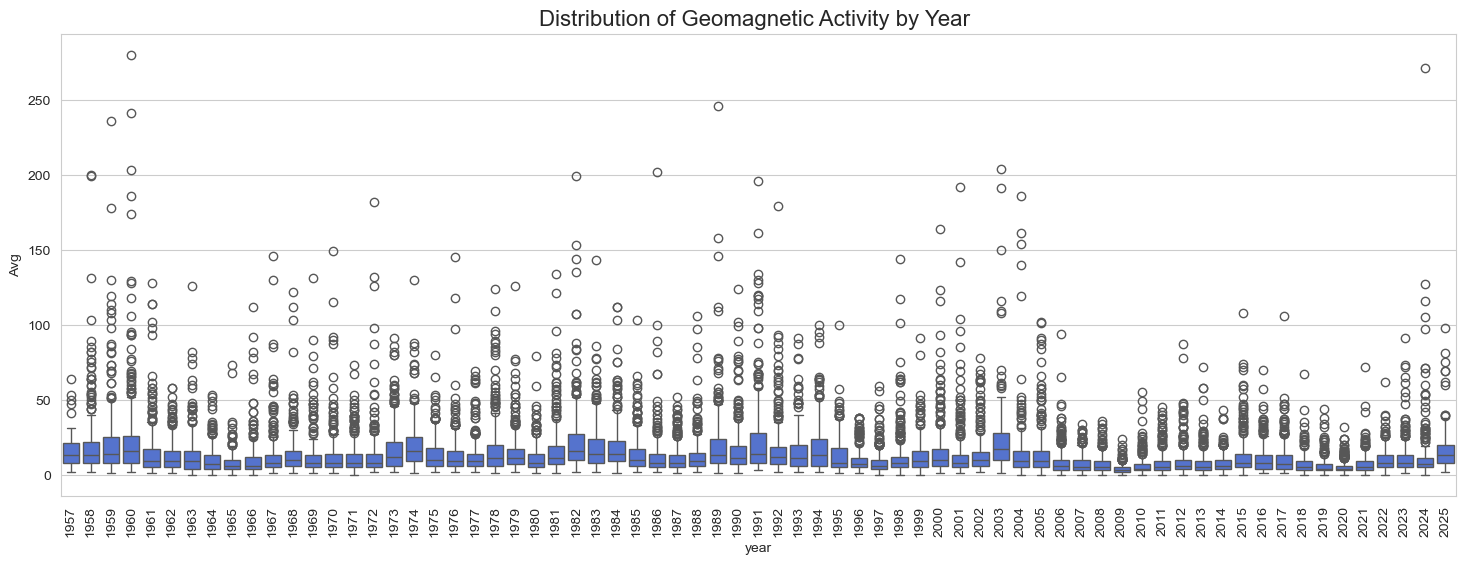

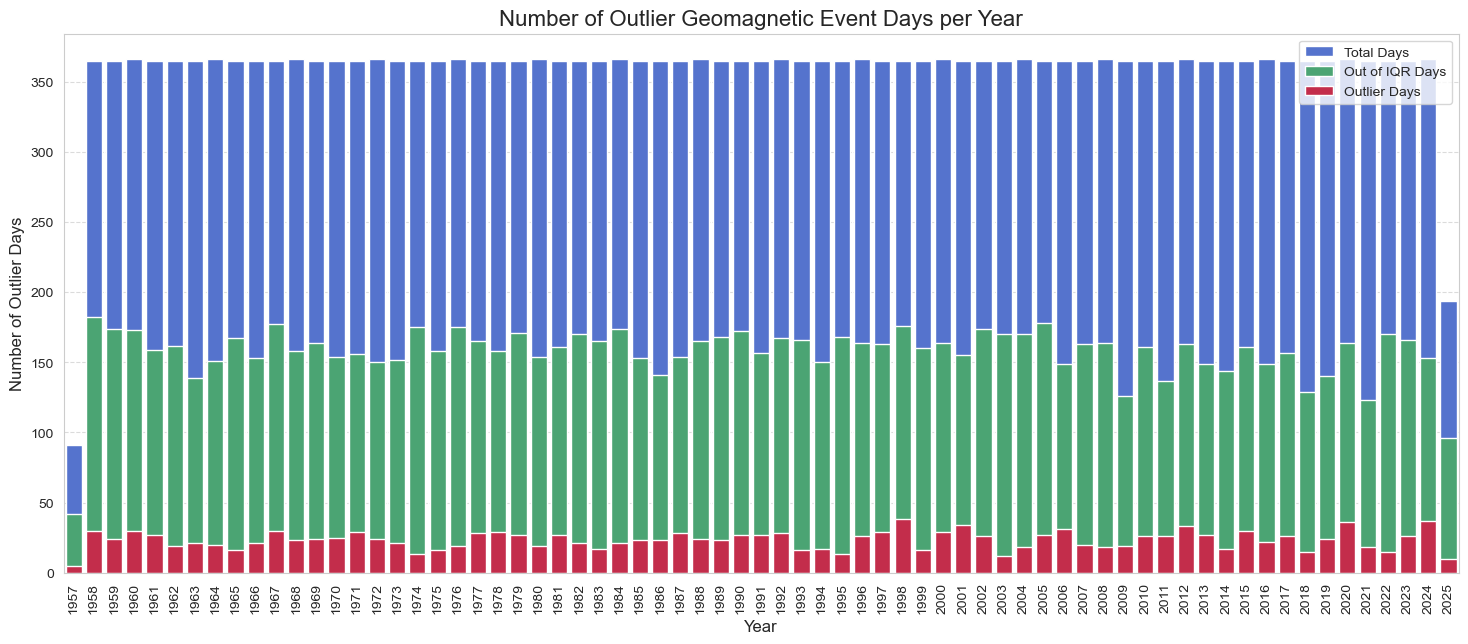

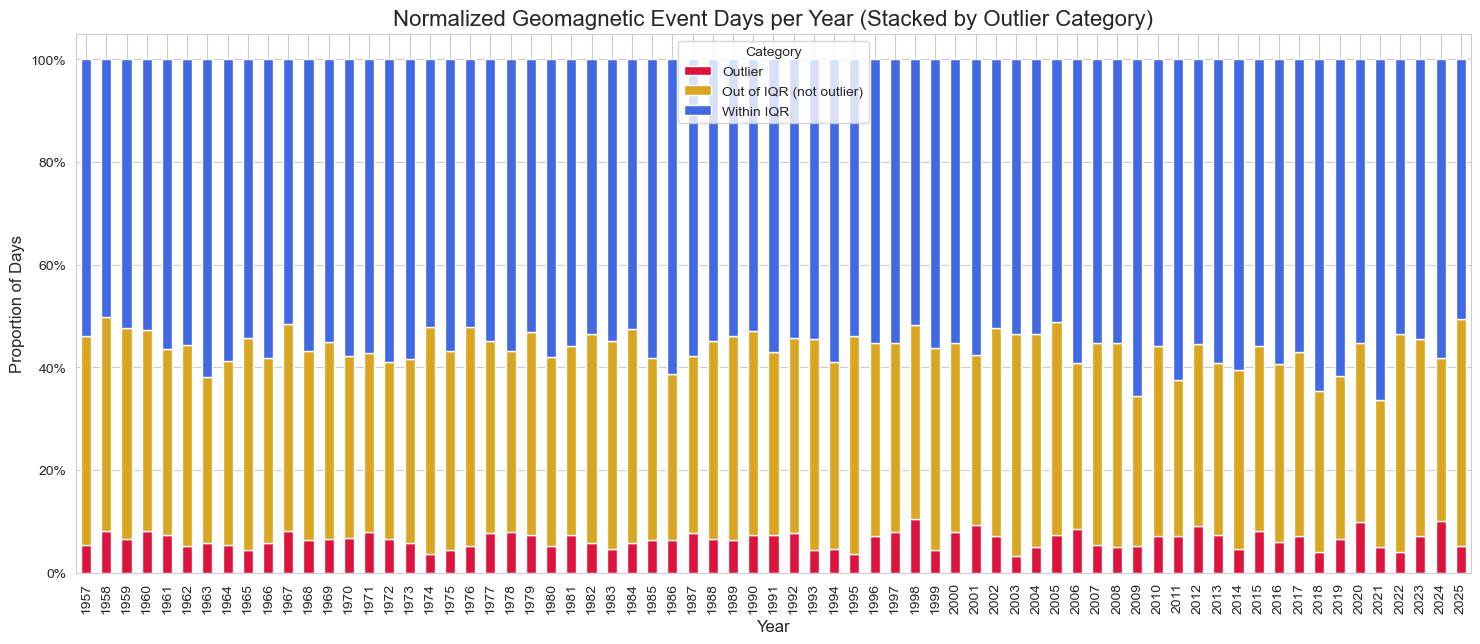

In [416]:
# 2.4. Box Plot of Geomagnetic Activity by Year based on the Ap Index

plt.figure(figsize=(18, 6))
ax = sns.boxplot(x='year', y='Avg', data=space_weather_df,color = 'royalblue')
plt.title('Distribution of Geomagnetic Activity by Year ',fontsize=16)
plt.xticks(rotation=90)
plt.show()

#######################################################################################################################
# 2.5. Overlayed Bar plot for Geomagnetic Activity by Year based on the Ap Index

# Dictionary to store the categories(full, outof, outlier) counts for each year
full_counts = {}
out_of_iqr_counts = {}
outlier_counts = {}

# Group data by year and calculate outliers for each group
full_count_years = []
full_count_values = []

out_of_iqr_years = []
out_of_iqr_values = []
outlier_years = []
outlier_values = []
for year, group_data in space_weather_df.groupby('year'):
    # Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = group_data['Avg'].quantile(0.25)
    Q3 = group_data['Avg'].quantile(0.75)
    
    # Interquartile Range (IQR)
    IQR = Q3 - Q1
    
    # Outlier boundaries - whiskers
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    
    # Threshold in the current year's group

    out_of_iqr = group_data[(group_data['Avg'] > Q3) | (group_data['Avg'] < Q1)]
    outliers = group_data[(group_data['Avg'] > upper_bound) | (group_data['Avg'] < lower_bound)]
    
    # Count the number of each category and store it
    full_counts[year] = len(group_data)
    out_of_iqr_counts[year] = len(out_of_iqr)
    outlier_counts[year] = len(outliers)
    
    # Store years and values for overlay plot
    full_count_years.extend([year] * len(group_data))
    full_count_values.extend(group_data['Avg'].values)
    out_of_iqr_years.extend([year] * len(out_of_iqr))
    out_of_iqr_values.extend(out_of_iqr['Avg'].values)
    outlier_years.extend([year] * len(outliers))
    outlier_values.extend(outliers['Avg'].values)




# Convert the dictionary to a pandas Series to plotting
full_count_series = pd.Series(full_counts).sort_index()
out_of_iqr_counts_series = pd.Series(out_of_iqr_counts).sort_index()
outlier_counts_series = pd.Series(outlier_counts).sort_index()
plt.figure(figsize=(18, 7))


# Overlay scatter plots of outlier values (for each year, plot the outlier F10.7_adj values)

sns.barplot(x=full_count_series.index, y=full_count_series.values,
                         color='royalblue', label='Total Days')

sns.barplot(x=out_of_iqr_counts_series.index, y=out_of_iqr_counts_series.values,
             color='mediumseagreen', label='Out of IQR Days')

sns.barplot(x=outlier_counts_series.index, y=outlier_counts_series.values, color='crimson', label='Outlier Days')



plt.title('Number of Outlier Geomagnetic Event Days per Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Outlier Days', fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend()
plt.show()

#######################################################################################################################

# 2.6. Normalised Stacked Bar plot for Ap_avg by Year


# Calculate the three categories for each year
years = full_count_series.index

# Non-outlier (within IQR): full_count - out_of_iqr
within_iqr = full_count_series - out_of_iqr_counts_series

# Out of IQR but not outlier: out_of_iqr - outlier
out_of_iqr_not_outlier = out_of_iqr_counts_series - outlier_counts_series

# Outliers
outliers = outlier_counts_series


stacked_df = pd.DataFrame({
    'Outlier': outliers,
    'Out of IQR (not outlier)': out_of_iqr_not_outlier,
    'Within IQR': within_iqr
}, index=years)


stacked_df.div(stacked_df.sum(axis=1), axis=0).plot( # .div divides each value by the sum of its row to calculate percentages
                                                    kind='bar',
                                                    stacked=True,
                                                    figsize=(18, 7),
                                                    color=[ 'crimson', 'goldenrod','royalblue']
                                                   )

plt.title('Normalized Geomagnetic Event Days per Year (Stacked by Outlier Category)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Proportion of Days', fontsize=12)
plt.xticks(rotation=90)
plt.legend(title='Category')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.show()

### 2.8. Box Plot of F10.7_adj by Year

This box plot gives a clear picture of the long-term behaviour of the F10.7 solar flux. You can clearly see the ~11-year solar cycle, with noticeable peaks and dips that line up with solar maximums and minimums over the decades.

This cyclical trend is key to changes in upper-atmosphere density, and by extention the amount of drag acting on LEO satellites. So this confirms that F10.7_adj is doing exactly what we’d want, it is capturing the slow-moving, consistent energy input into the system which is vital to understanding the underlying relationship between solar activity and orbital decay.

### 2.9. Overlayed Bar plot for F10.7_adj by Year



### 2.10. Normalised Stacked Bar plot for F10.7_adj by Year

This plot gives a normalized view of F10.7 solar flux across the years, breaking down how often each year had calm, moderately active, or high-activity (outlier) days. You can clearly spot the ~11-year solar cycle, with spikes in active and outlier days lining up with solar maximums.

This reinforces that the F10.7 feature is capturing the steady, long-term energy input that shapes the satellite’s environment. 

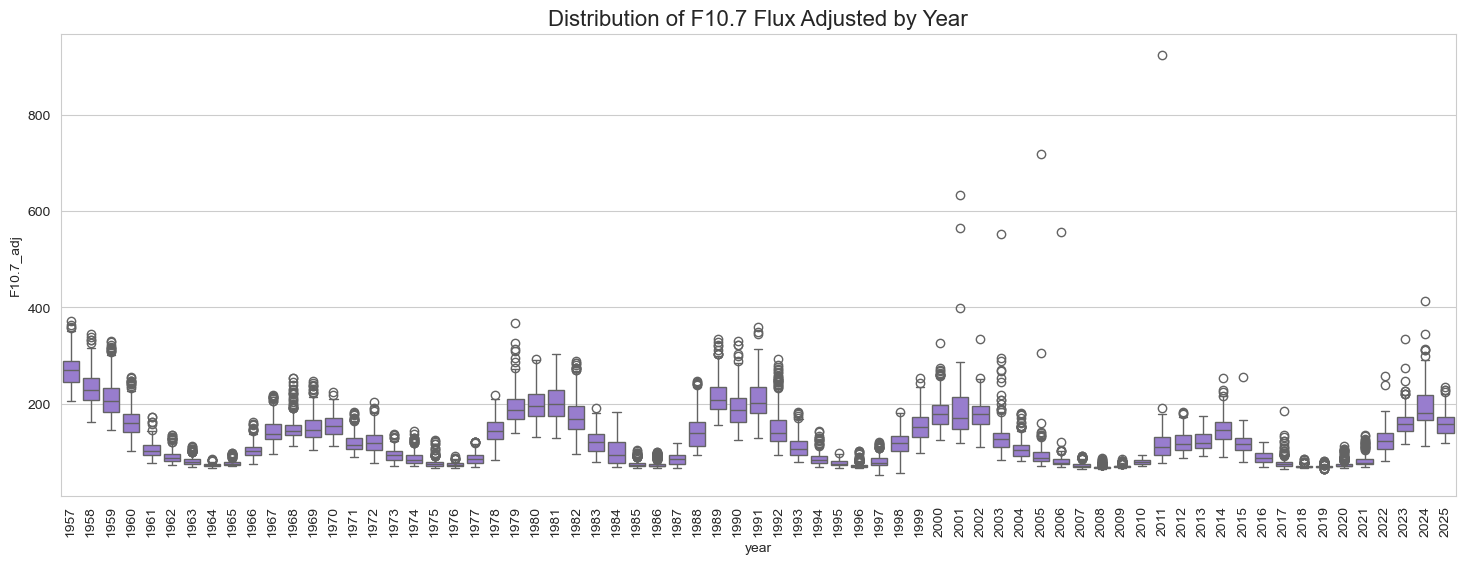

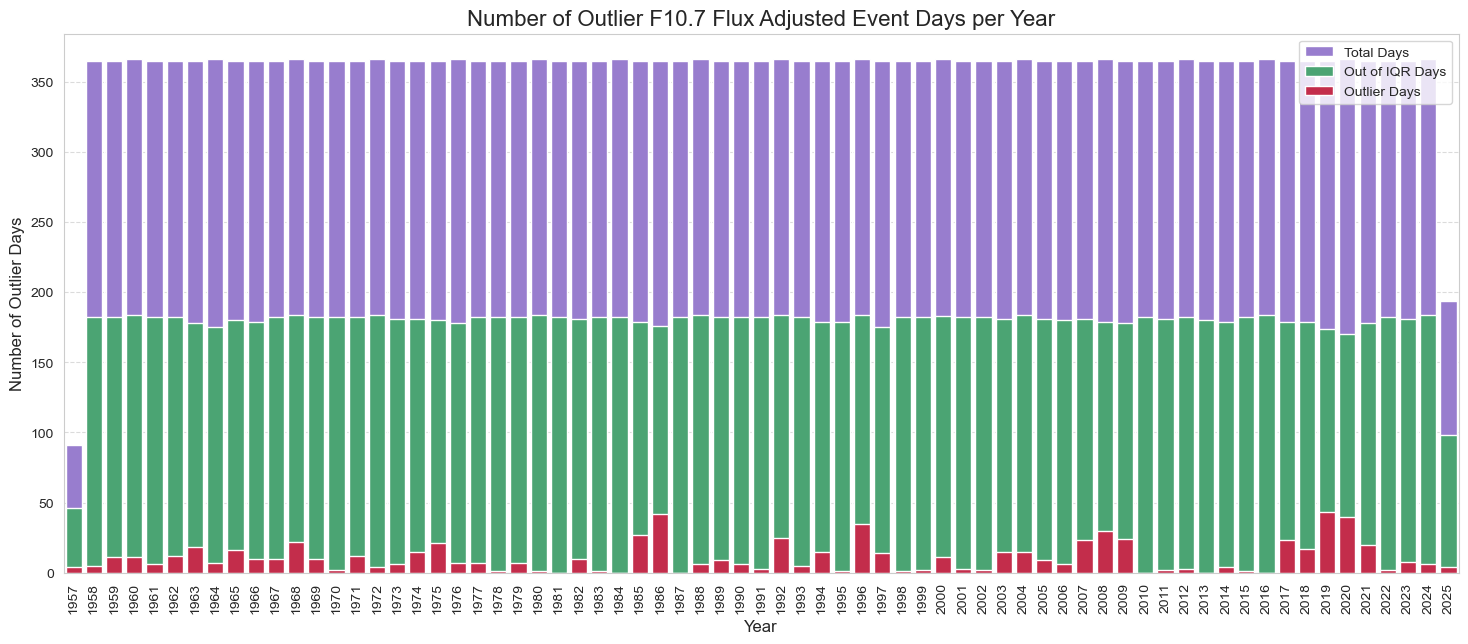

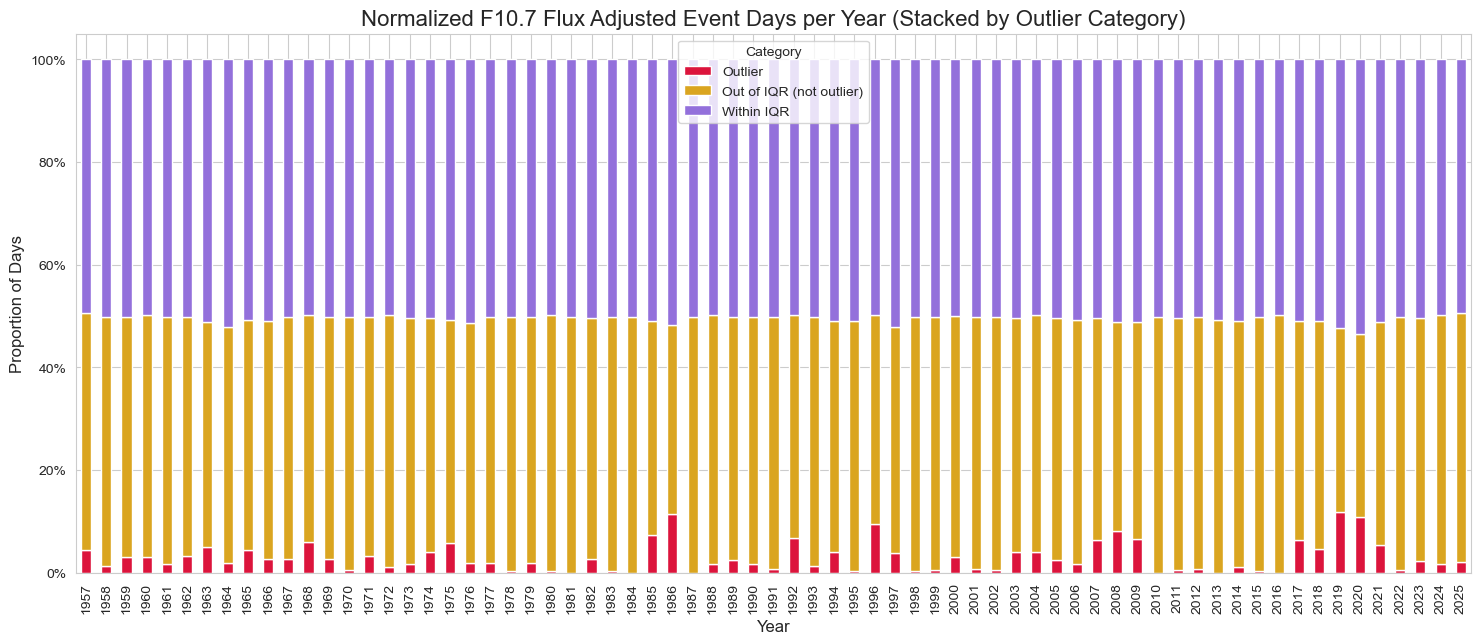

In [417]:
# 2.7. Box plot for F10.7_adj by Year
plt.figure(figsize=(18, 6))
ax = sns.boxplot(x='year', y='F10.7_adj', data=space_weather_df, color='mediumpurple')
plt.title('Distribution of F10.7 Flux Adjusted by Year', fontsize=16)
plt.xticks(rotation=90)
plt.show()

#######################################################################################################################
# 2.8. Overlayed Bar plot for F10.7_adj by Year

# Dictionary to store the categories(full, outof, outlier) counts for each year
full_counts = {}
out_of_iqr_counts = {}
outlier_counts = {}

# Group data by year and calculate outliers for each group
full_count_years = []
full_count_values = []

out_of_iqr_years = []
out_of_iqr_values = []
outlier_years = []
outlier_values = []
for year, group_data in space_weather_df.groupby('year'):
    # Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = group_data['F10.7_adj'].quantile(0.25)
    Q3 = group_data['F10.7_adj'].quantile(0.75)
    
    # Interquartile Range (IQR)
    IQR = Q3 - Q1
    
    # Outlier boundaries - whiskers
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    
    # Threshold in the current year's group

    out_of_iqr = group_data[(group_data['F10.7_adj'] > Q3) | (group_data['F10.7_adj'] < Q1)]
    outliers = group_data[(group_data['F10.7_adj'] > upper_bound) | (group_data['F10.7_adj'] < lower_bound)]
    
    # Count the number of each category and store it
    full_counts[year] = len(group_data)
    out_of_iqr_counts[year] = len(out_of_iqr)
    outlier_counts[year] = len(outliers)
    
    # Store years and values for overlay plot
    full_count_years.extend([year] * len(group_data))
    full_count_values.extend(group_data['F10.7_adj'].values)
    out_of_iqr_years.extend([year] * len(out_of_iqr))
    out_of_iqr_values.extend(out_of_iqr['F10.7_adj'].values)
    outlier_years.extend([year] * len(outliers))
    outlier_values.extend(outliers['F10.7_adj'].values)



# Convert the dictionary to a pandas Series to plotting
full_count_series = pd.Series(full_counts).sort_index()
out_of_iqr_counts_series = pd.Series(out_of_iqr_counts).sort_index()
outlier_counts_series = pd.Series(outlier_counts).sort_index()
plt.figure(figsize=(18, 7))


# Overlay scatter plots of outlier values (for each year, plot the outlier F10.7_adj values)

sns.barplot(x=full_count_series.index, y=full_count_series.values,
                         color='mediumpurple', label='Total Days')

sns.barplot(x=out_of_iqr_counts_series.index, y=out_of_iqr_counts_series.values,
             color='mediumseagreen', label='Out of IQR Days')

sns.barplot(x=outlier_counts_series.index, y=outlier_counts_series.values, color='crimson', label='Outlier Days')



plt.title('Number of Outlier F10.7 Flux Adjusted Event Days per Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Outlier Days', fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend()
plt.show()

#######################################################################################################################
# 2.9. Normalised Stacked Bar plot for F10.7_adj by Year


# Calculate the three categories for each year
years = full_count_series.index

# Non-outlier (within IQR): full_count - out_of_iqr
within_iqr = full_count_series - out_of_iqr_counts_series

# Out of IQR but not outlier: out_of_iqr - outlier
out_of_iqr_not_outlier = out_of_iqr_counts_series - outlier_counts_series

# Outliers
outliers = outlier_counts_series


stacked_df = pd.DataFrame({
    'Outlier': outliers,
    'Out of IQR (not outlier)': out_of_iqr_not_outlier,
    'Within IQR': within_iqr
}, index=years)


stacked_df.div(stacked_df.sum(axis=1), axis=0).plot( # .div divides each value by the sum of its row to calculate percentages
                                                    kind='bar',
                                                    stacked=True,
                                                    figsize=(18, 7),
                                                    color=[ 'crimson', 'goldenrod','mediumpurple']
                                                   )

plt.title('Normalized F10.7 Flux Adjusted Event Days per Year (Stacked by Outlier Category)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Proportion of Days', fontsize=12)
plt.xticks(rotation=90)
plt.legend(title='Category')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.show()


### 2.11. Correlation between F10.7_adj and Ap_avg

This scatter plot shows very little linear correlation between the long-term solar flux F10.7 and daily geomagnetic activity (Ap). The near-flat regression line shows they’re picking up on totally different behaviours — the slow-moving solar cycle vs. short, spiky geomagnetic storms. That separation is exactly what we want, and it justifies keeping both features in the model as they bring distinct, non-redundant signals.

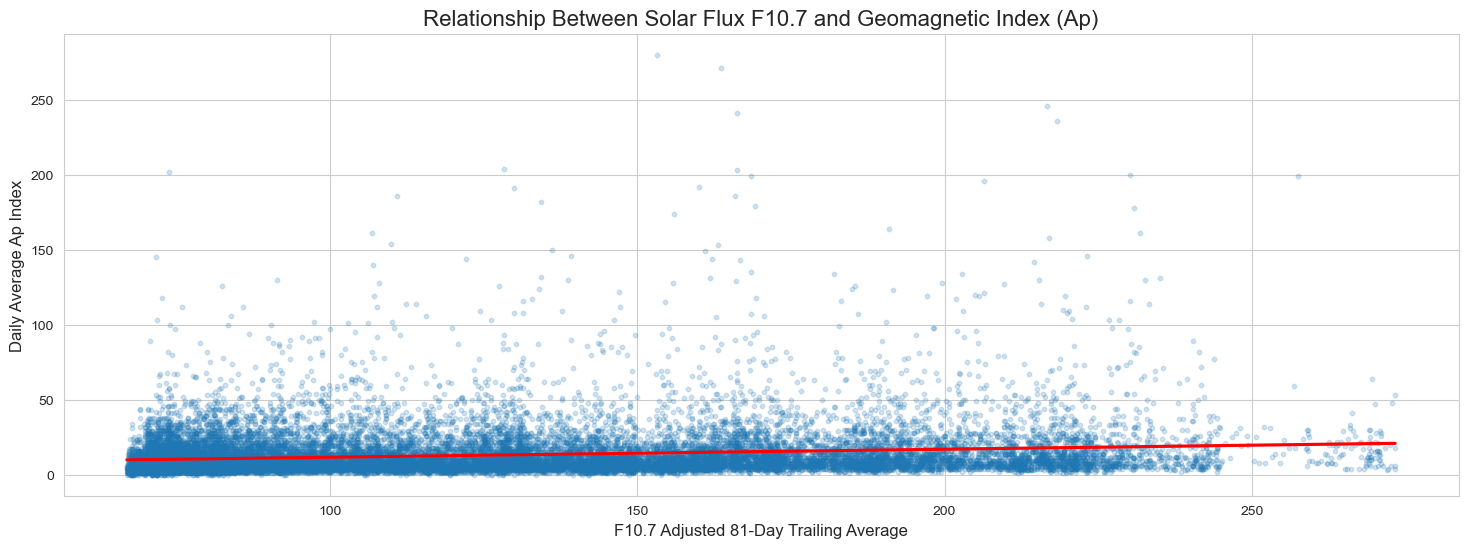


Spearman Correlation Coefficient: 0.2390


In [439]:

plt.figure(figsize=(18, 6))
sns.regplot(
            x='Lst81_adj',
            y='Avg',
            data=space_weather_df,
            scatter_kws={'alpha': 0.2, 's': 10},
            line_kws={'color': 'red'}
           )

plt.title('Relationship Between Solar Flux F10.7 and Geomagnetic Index (Ap)', fontsize=16)
plt.xlabel('F10.7 Adjusted 81-Day Trailing Average', fontsize=12)
plt.ylabel('Daily Average Ap Index', fontsize=12)
plt.show()

spearman_corr = space_weather_df['Lst81_adj'].corr(space_weather_df['Avg'], method='spearman')
print(f"\nSpearman Correlation Coefficient: {spearman_corr:.4f}")




### 2.12. Correlation Analysis - Orbital Elements

The correlation matrix shows that our main orbital features (mean_motion, eccentricity, inclination, and bstar) aren’t strongly correlated with each other, which is exactly what we want. It means there’s no major multicollinearity, and each feature is likely bringing something different to the table.

There are also a couple of interesting patterns. bstar has a moderate correlation with year (0.50), which suggests it’s been updated over time, making it a useful feature. There’s also a 0.42 correlation between month and inclination, pointing to a slight seasonal oscillation in the orbit’s tilt. That supports using engineered cyclical time features like sine/cosine of day-of-year instead of raw month values, since they’re better at capturing patterns like this

In [419]:
tle_df_sorted = tle_df.sort_values(by='tle_date')

# Split 'tle_date' into separate columns for day, month, year, and time, keeping the original column
tle_df_sorted['year'] = tle_df_sorted['tle_date'].dt.year
tle_df_sorted['month'] = tle_df_sorted['tle_date'].dt.month
tle_df_sorted['day'] = tle_df_sorted['tle_date'].dt.day
tle_df_sorted['time'] = tle_df_sorted['tle_date'].dt.time

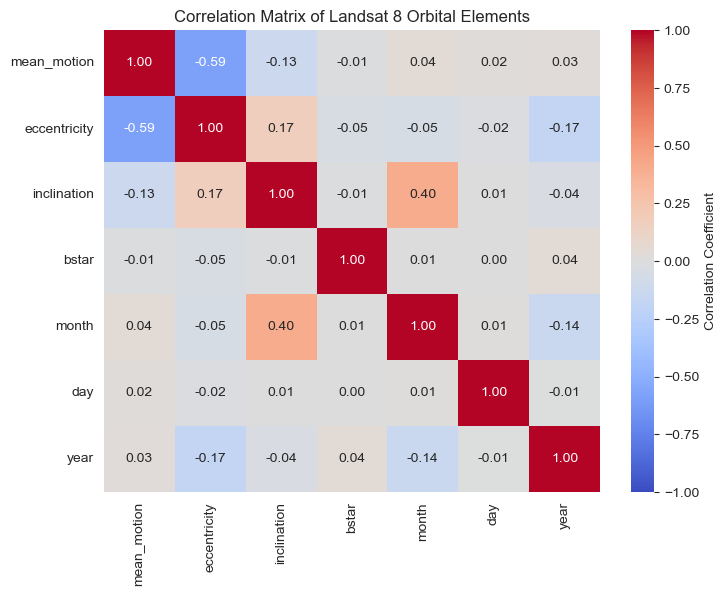

In [420]:
# Correlation matrix for tle_df_sorted (orbital elements)
corr_matrix = tle_df_sorted[['mean_motion', 'eccentricity', 'inclination', 'bstar', 'month', 'day','year']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
            corr_matrix,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            center=0,
            vmin=-1,
            vmax=1,
            cbar_kws={'label': 'Correlation Coefficient'}
            )
plt.title('Correlation Matrix of Landsat 8 Orbital Elements')
plt.show()

### 2.13. Time-series plot of Landsat 8 satellitle orbital elements

The time-series plots show a period of instability in the satellite’s orbit right at the start of the dataset, likely linked to its post-launch stabilisation. To avoid this early variance impacting the model, we trim the data to start from the 110th row — once the satellite has reached a stable operational state.

Even after trimming out the post-launch phase, a few outliers still show up in the time-series plots of the orbital elements. These are likely due to occasional tracking glitches or random disturbances. Luckily, the models we’re using especially XGBoost are generally robust to this kind of noise, so these outliers shouldn’t get in the way of learning the core patterns in the data.

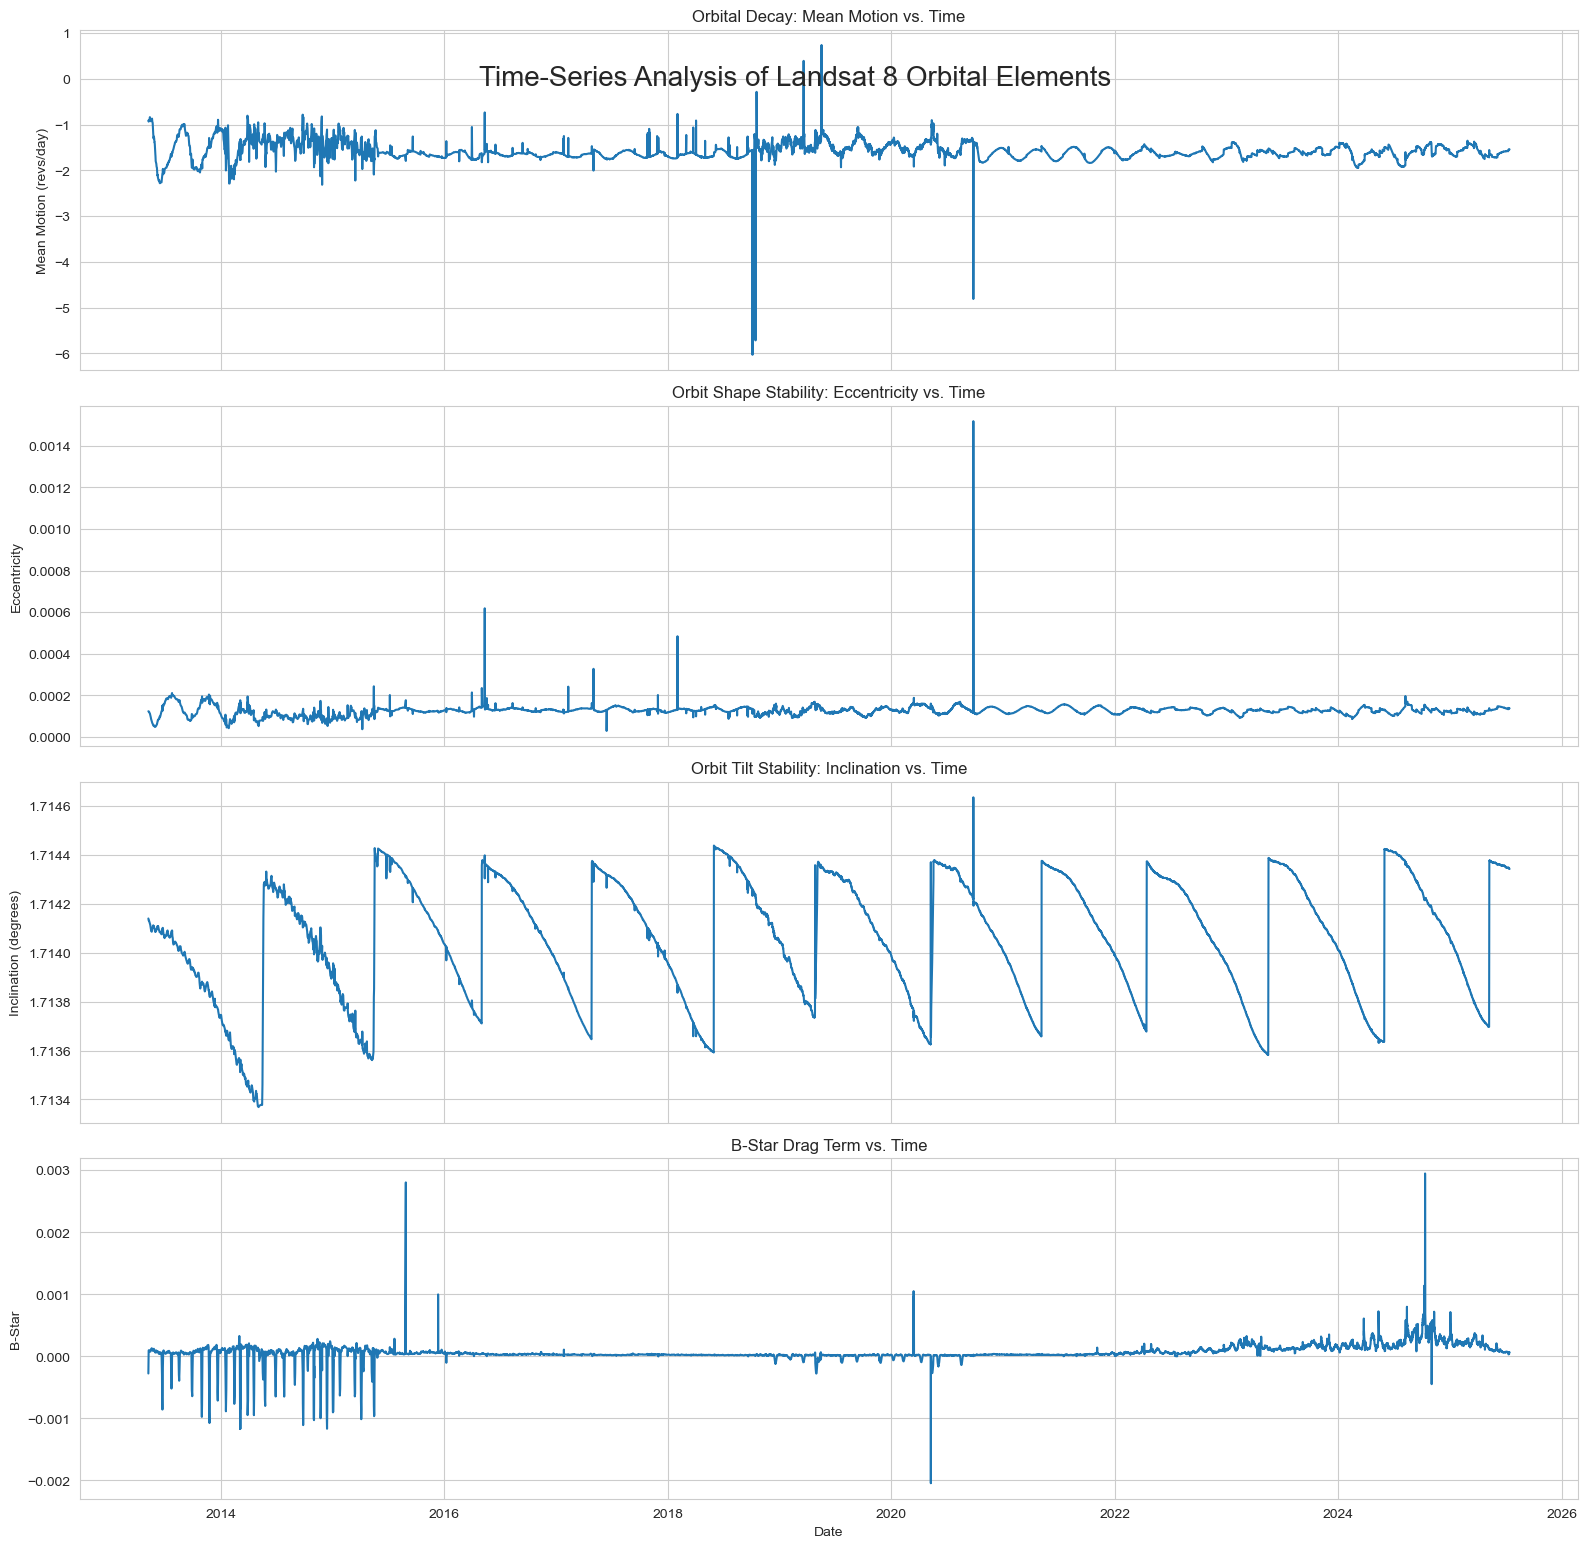

In [421]:
# Time-series plot of Landsat 8 satellitle orbital elements
tle_df_sorted = tle_df_sorted.iloc[110:]
fig, axes = plt.subplots(4, 1, figsize=(16, 16), sharex=True)
fig.suptitle('Time-Series Analysis of Landsat 8 Orbital Elements', fontsize=20, y=0.93)

# Mean Motion
sns.lineplot(ax=axes[0], x='tle_date', y='mean_motion', data=tle_df_sorted)
axes[0].set_title('Orbital Decay: Mean Motion vs. Time')
axes[0].set_ylabel('Mean Motion (revs/day)')
axes[0].grid(True)

# Eccentricity
sns.lineplot(ax=axes[1], x='tle_date', y='eccentricity', data=tle_df_sorted)
axes[1].set_title('Orbit Shape Stability: Eccentricity vs. Time')
axes[1].set_ylabel('Eccentricity')
axes[1].grid(True)

# Inclination
sns.lineplot(ax=axes[2], x='tle_date', y='inclination', data=tle_df_sorted)
axes[2].set_title('Orbit Tilt Stability: Inclination vs. Time')
axes[2].set_ylabel('Inclination (degrees)')
axes[2].grid(True)

# B-Star Drag Term
sns.lineplot(ax=axes[3], x='tle_date', y='bstar', data=tle_df_sorted)
axes[3].set_title('B-Star Drag Term vs. Time')
axes[3].set_ylabel('B-Star')
axes[3].set_xlabel('Date')
axes[3].grid(True)

plt.tight_layout()
plt.show()


### 2.14. StdDev as a Percentage of daily mean of of each orbital element

The plots shows that mean_motion, eccentricity, and bstar all show significant intra-day variance, with spikes sometimes exceeding 100% of the daily mean. In contrast, inclination stands out as highly stable, with variations consistently below 0.035%, making it the only steady orbital parameter. 

We understand that for features like eccentricity and bstar, these large percentage changes are driven by their very small mean values; the actual physical changes are minimal. However, even these small deviations can accumulate over time, contributing to discrepancies between predicted and observed satellite pass times. This finding suggests that a more fine-grained merging strategy could improve model fidelity.

As this project has a limited time the approach for the experimental project will use a daily merge and — it’s not just for simplicity, it’s backed by the data and keeps things interpretable

The average TLE features of each day will be used to represent the orbital state, merged with the corresponding daily-averaged space weather values. The intra-day variability is noted as an important insight and would be a promising direction for future work.

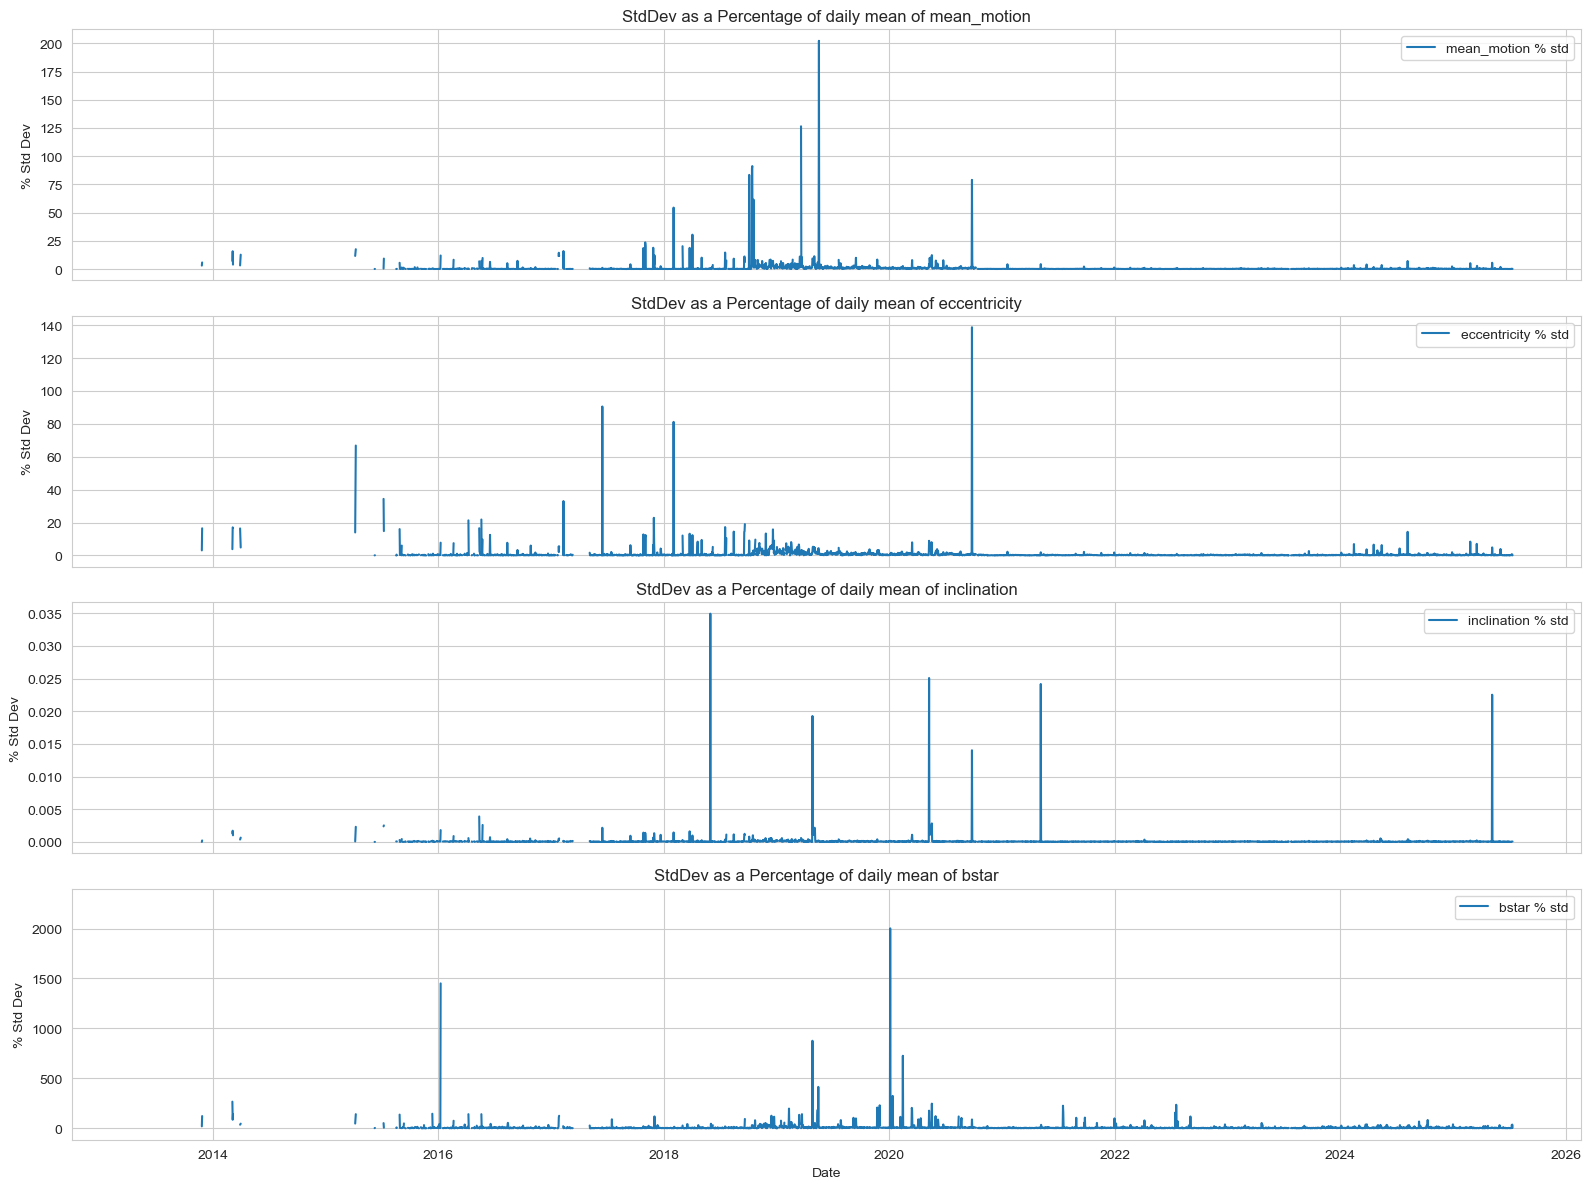

In [428]:
# Group by year, month, day and calculate mean and std for each feature
daily_stats = tle_df_sorted.groupby(['year', 'month', 'day'])[['mean_motion', 'eccentricity', 'inclination', 'bstar']].agg(['mean', 'std']).reset_index()

# Calculate percentage std: (std / mean) * 100 for each feature
for feat in ['mean_motion', 'eccentricity', 'inclination', 'bstar']:
    daily_stats[(feat, 'std_pct')] = (daily_stats[(feat, 'std')] / daily_stats[(feat, 'mean')]).abs() * 100

daily_stats['date_'] = pd.to_datetime(
                                    daily_stats[('year', '')].astype(str) + '-' +
                                    daily_stats[('month', '')].astype(str) + '-' +
                                    daily_stats[('day', '')].astype(str)
                                   )

# Daily percentage std for each feature in separate subplots
fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)
features = ['mean_motion', 'eccentricity', 'inclination', 'bstar']
for i, feat in enumerate(features):
    axes[i].plot(daily_stats['date_'], daily_stats[(feat, 'std_pct')], label=f'{feat} % std')
    axes[i].set_ylabel('% Std Dev')
    axes[i].set_title(f'StdDev as a Percentage of daily mean of {feat}')
    axes[i].legend()

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()


## 3. Data Preprocessing and Feature Engineering 

As our model is trying to correct the errors in the predictions made by the SGP4 physics model we will need to create our predictions before merging the two datasets.

### 3.1. Predicting the mean motion using the Skyfield python library

As mentioned earlier, the goal of our model is to correct the predictions made by the standard SGP4 physics model. In this step, we use the skyfield library to run the SGP4 propagator and predict the satellite’s mean motion two days ahead. Our target variable, prediction_error, is then calculated as the difference between this physics-based prediction and the actual observed mean motion.

In [429]:
# Predict SGP4 mean motion 2 days ahead and calculate prediction error

# Copy the sorted TLE dataframe
tle_df_pred = tle_df_sorted.copy()

# Prepare Skyfield timescale and a lookup dictionary for satellite objects by TLE epoch
# (satellites and ts are already defined in previous cells)
satellite_dict = {sat.epoch.utc_datetime(): sat for sat in satellites}

# Set prediction interval (2 days)
prediction_days = 2

# List to store prediction errors
sgp4_errors = []


# Iterate over each row in tle_df_pred
for idx, row in tle_df_pred.iterrows():
    # Get the Skyfield satellite object for this TLE epoch
    current_sat = satellite_dict.get(row['tle_date'].to_pydatetime())
    if current_sat is None:
        sgp4_errors.append(np.nan)
        continue

    # SGP4 prediction: n(t) = n_0 + (n_dot * t)
    # where n_0 is the mean motion at epoch and n_dot is the rate of change of mean motion (TLE stores n_dot/2)
    # Note: n_dot is multiplied by 2 because TLE stores it as half the value

    n_0 = current_sat.model.mm  # mean motion at epoch
    n_dot = current_sat.model.ndot * 2  

    sgp4_predicted_mm = n_0 + (n_dot * prediction_days)

    # Find the actual mean_motion value 2 days in the future (by index offset)
    future_idx = idx + prediction_days
    if future_idx in tle_df_pred.index:
        actual_future_mm = tle_df_pred.loc[future_idx, 'mean_motion']
        error = actual_future_mm - sgp4_predicted_mm
        sgp4_errors.append(error)
    else:
        sgp4_errors.append(np.nan)

# Add prediction error as a new column
new_col = f'{prediction_days} day prediction error'
tle_df_pred[new_col] = sgp4_errors

# Drop rows with NaN errors (end of the dataset)
tle_df_pred = tle_df_pred.dropna(subset=[new_col])

tle_df_pred[['mean_motion', new_col]].head()


,mean_motion,2 day prediction error
110,-0.912308,-0.001487
111,-0.936086,0.021221
112,-0.913795,0.018464
113,-0.914865,0.028175
114,-0.895331,0.056634


### 3.2. Data Merge

Here we’re merging the TLE data with the space weather data into a single master_df. This puts the ‘cause’—solar and geomagnetic activity—and the ‘effect’—changes in the satellite’s orbit on the same row for each day. It’s a crucial step that lets the model actually learn the relationships between them.

As we have previously mentioned for the LTE data we will be calculating the daily average for each feature and also will include the last TLE of the day value as well as the daily standard deviation. This gives the model the best possible information: it knows the most recent state of the satellite, and it knows how stable or noisy that state was throughout the day.

In [432]:
# Group TLE data by date (ignoring time)
tle_df_pred['date'] = pd.to_datetime(tle_df_pred['tle_date'].dt.date)
daily_grouper = tle_df_pred.groupby(tle_df_pred['date'])

# Calculate daily standard deviation for each orbital element and add '_std' suffix
daily_std_devs = daily_grouper[['mean_motion', 'eccentricity', 'inclination', 'bstar']].std().add_suffix('_std')

# Fill NaN std values (days with only one TLE) with 0
daily_std_devs.fillna(0, inplace=True)

# Get the last TLE entry for each day (most recent state)
last_tle_per_day = daily_grouper.last()

# Merge last TLE state with daily standard deviations using date as index
enriched_tle_df = pd.merge(last_tle_per_day, daily_std_devs, left_index=True, right_index=True)


In [433]:

# Merge TLE data with space weather data
# Both DataFrames have 'date' as index for merging
master_df = pd.merge(
                        enriched_tle_df,
                        space_weather_df,
                        left_index=True,
                        right_on='date',
                        how='left', suffixes=('_tle', '_sw')
                    )

# Convert 'date' to datetime and set as index
master_df.set_index('date', inplace=True)


# Fill NaN values in the master DataFrame

#master_df.fillna(method='ffill', inplace=True)

# Remove the name from the index to clean up the display
master_df.index.name = None

# Remove the last row from master_df
master_df = master_df.iloc[:-1]
master_df.head()

,tle_date,mean_motion,eccentricity,inclination,bstar,year_tle,month_tle,day_tle,time,2 day prediction error,mean_motion_std,eccentricity_std,inclination_std,bstar_std,year_sw,month_sw,day_sw,BSRN,ND,Kp1,Kp2,Kp3,Kp4,Kp5,Kp6,Kp7,Kp8,Sum,Ap1,Ap2,Ap3,Ap4,Ap5,Ap6,Ap7,Ap8,Avg,Cp,C9,ISN,F10.7_adj,Q,Ctr81_adj,Lst81_adj,F10.7_obs,Ctr81_obs,Lst81_obs
2013-05-09,2013-05-09 08:21:49.525635+00:00,-0.912308,0.000123,1.714140,-0.000279,2013,5,9,08:21:49.525635,-0.001487,0.000000,0.000000e+00,0.000000,0.000000,2013,5,9.0,2452.0,24.0,13.0,13.0,10.0,13.0,7.0,7.0,3.0,3.0,70.0,5.0,5.0,4.0,5.0,3.0,3.0,2.0,2.0,4.0,0.1,0.0,116.0,130.9,0.0,125.3,118.3,128.4,123.1,118.4
2013-05-10,2013-05-10 07:26:12.924377+00:00,-0.936086,0.000121,1.714133,0.000093,2013,5,10,07:26:12.924377,0.021221,0.000000,0.000000e+00,0.000000,0.000000,2013,5,10.0,2452.0,25.0,10.0,13.0,7.0,13.0,13.0,3.0,7.0,3.0,70.0,4.0,5.0,3.0,5.0,5.0,2.0,3.0,2.0,4.0,0.1,0.0,125.0,127.3,0.0,125.5,118.6,124.8,123.3,118.7
2013-05-11,2013-05-11 13:06:08.795258+00:00,-0.914865,0.000120,1.714131,0.000081,2013,5,11,13:06:08.795258,0.028175,0.000757,7.071068e-07,0.000001,0.000004,2013,5,11.0,2452.0,26.0,0.0,13.0,7.0,10.0,3.0,3.0,7.0,7.0,50.0,0.0,5.0,3.0,4.0,2.0,2.0,3.0,3.0,3.0,0.0,0.0,134.0,139.4,0.0,125.7,119.0,136.6,123.4,119.0
2013-05-12,2013-05-12 07:13:53.008636+00:00,-0.895331,0.000118,1.714128,0.000091,2013,5,12,07:13:53.008636,0.056634,0.000000,0.000000e+00,0.000000,0.000000,2013,5,12.0,2452.0,27.0,10.0,17.0,7.0,10.0,3.0,10.0,3.0,3.0,63.0,4.0,6.0,3.0,4.0,2.0,4.0,2.0,2.0,3.0,0.1,0.0,142.0,150.4,0.0,125.9,119.5,147.3,123.6,119.4
2013-05-13,2013-05-13 07:57:09.593018+00:00,-0.886690,0.000115,1.714123,0.000085,2013,5,13,07:57:09.593018,0.004423,0.000000,0.000000e+00,0.000000,0.000000,2013,5,13.0,2453.0,1.0,7.0,10.0,13.0,7.0,7.0,23.0,10.0,3.0,80.0,3.0,4.0,5.0,3.0,3.0,9.0,4.0,2.0,4.0,0.1,0.0,153.0,153.5,0.0,126.1,120.1,150.3,123.7,119.9


In [434]:
master_df.isna().sum()

tle_date                  0
mean_motion               0
eccentricity              0
inclination               0
bstar                     0
year_tle                  0
month_tle                 0
day_tle                   0
time                      0
2 day prediction error    0
mean_motion_std           0
eccentricity_std          0
inclination_std           0
bstar_std                 0
year_sw                   0
month_sw                  0
day_sw                    0
BSRN                      0
ND                        0
Kp1                       0
Kp2                       0
Kp3                       0
Kp4                       0
Kp5                       0
Kp6                       0
Kp7                       0
Kp8                       0
Sum                       0
Ap1                       0
Ap2                       0
Ap3                       0
Ap4                       0
Ap5                       0
Ap6                       0
Ap7                       0
Ap8                 

### 3.3. Preliminary Feature Selection 

Based on the EDA, we’re now finalising the feature set by dropping columns that are redundant or add little value. The 3-hourly Kp and Ap indices are removed since their signals are already captured by the daily AP_AVG. We’re also dropping BSRN, ISN, and C9 due to either high correlation with other features or low granularity.

To avoid data leakage, we exclude any centered-average (Ctr81) or observed (_obs) solar flux values, and drop raw date components since they’ll be replaced with engineered cyclical features. The result is a cleaner, more focused feature set with better interpretability and less noise going into the model.



In [445]:
master_df_fs = master_df.copy()

master_df_fs.drop(columns=['year_sw', 'month_sw', 'day_sw', 'Kp1','Kp2', 'Kp3','Kp4', 'Kp5','Kp6', 'Kp7','Kp8','Sum','Ap1','Ap2', 'Ap3','Ap4', 'Ap5','Ap6', 'Ap7','Ap8','BSRN','ND',
                           'ISN','Cp','C9','F10.7_obs','Ctr81_adj','Ctr81_obs', 'Lst81_obs','Q'], inplace=True)
master_df_fs

,tle_date,mean_motion,eccentricity,inclination,bstar,year_tle,month_tle,day_tle,time,2 day prediction error,mean_motion_std,eccentricity_std,inclination_std,bstar_std,Avg,F10.7_adj,Lst81_adj
2013-05-09,2013-05-09 08:21:49.525635+00:00,-0.912308,0.000123,1.714140,-0.000279,2013,5,9,08:21:49.525635,-0.001487,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.0,130.9,118.3
2013-05-10,2013-05-10 07:26:12.924377+00:00,-0.936086,0.000121,1.714133,0.000093,2013,5,10,07:26:12.924377,0.021221,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.0,127.3,118.6
2013-05-11,2013-05-11 13:06:08.795258+00:00,-0.914865,0.000120,1.714131,0.000081,2013,5,11,13:06:08.795258,0.028175,0.000757,7.071068e-07,1.234134e-06,3.806356e-06,3.0,139.4,119.0
2013-05-12,2013-05-12 07:13:53.008636+00:00,-0.895331,0.000118,1.714128,0.000091,2013,5,12,07:13:53.008636,0.056634,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,3.0,150.4,119.5
2013-05-13,2013-05-13 07:57:09.593018+00:00,-0.886690,0.000115,1.714123,0.000085,2013,5,13,07:57:09.593018,0.004423,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.0,153.5,120.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-08,2025-07-08 19:33:20.952576+00:00,-1.582345,0.000134,1.714348,0.000063,2025,7,8,19:33:20.952576,0.023860,0.002162,3.109126e-07,0.000000e+00,8.131291e-07,12.0,119.7,139.2
2025-07-09,2025-07-09 18:37:43.477814+00:00,-1.583998,0.000133,1.714348,0.000062,2025,7,9,18:37:43.477814,0.034133,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,7.0,124.3,138.8
2025-07-10,2025-07-10 17:42:06.924957+00:00,-1.551812,0.000138,1.714348,0.000029,2025,7,10,17:42:06.924957,0.001276,0.003887,8.845903e-07,8.726646e-07,1.627965e-05,2.0,133.8,138.5
2025-07-11,2025-07-11 21:43:09.561768+00:00,-1.553360,0.000137,1.714346,0.000030,2025,7,11,21:43:09.561768,0.003540,0.001391,1.643168e-07,9.559562e-07,7.166160e-07,17.0,136.8,138.2


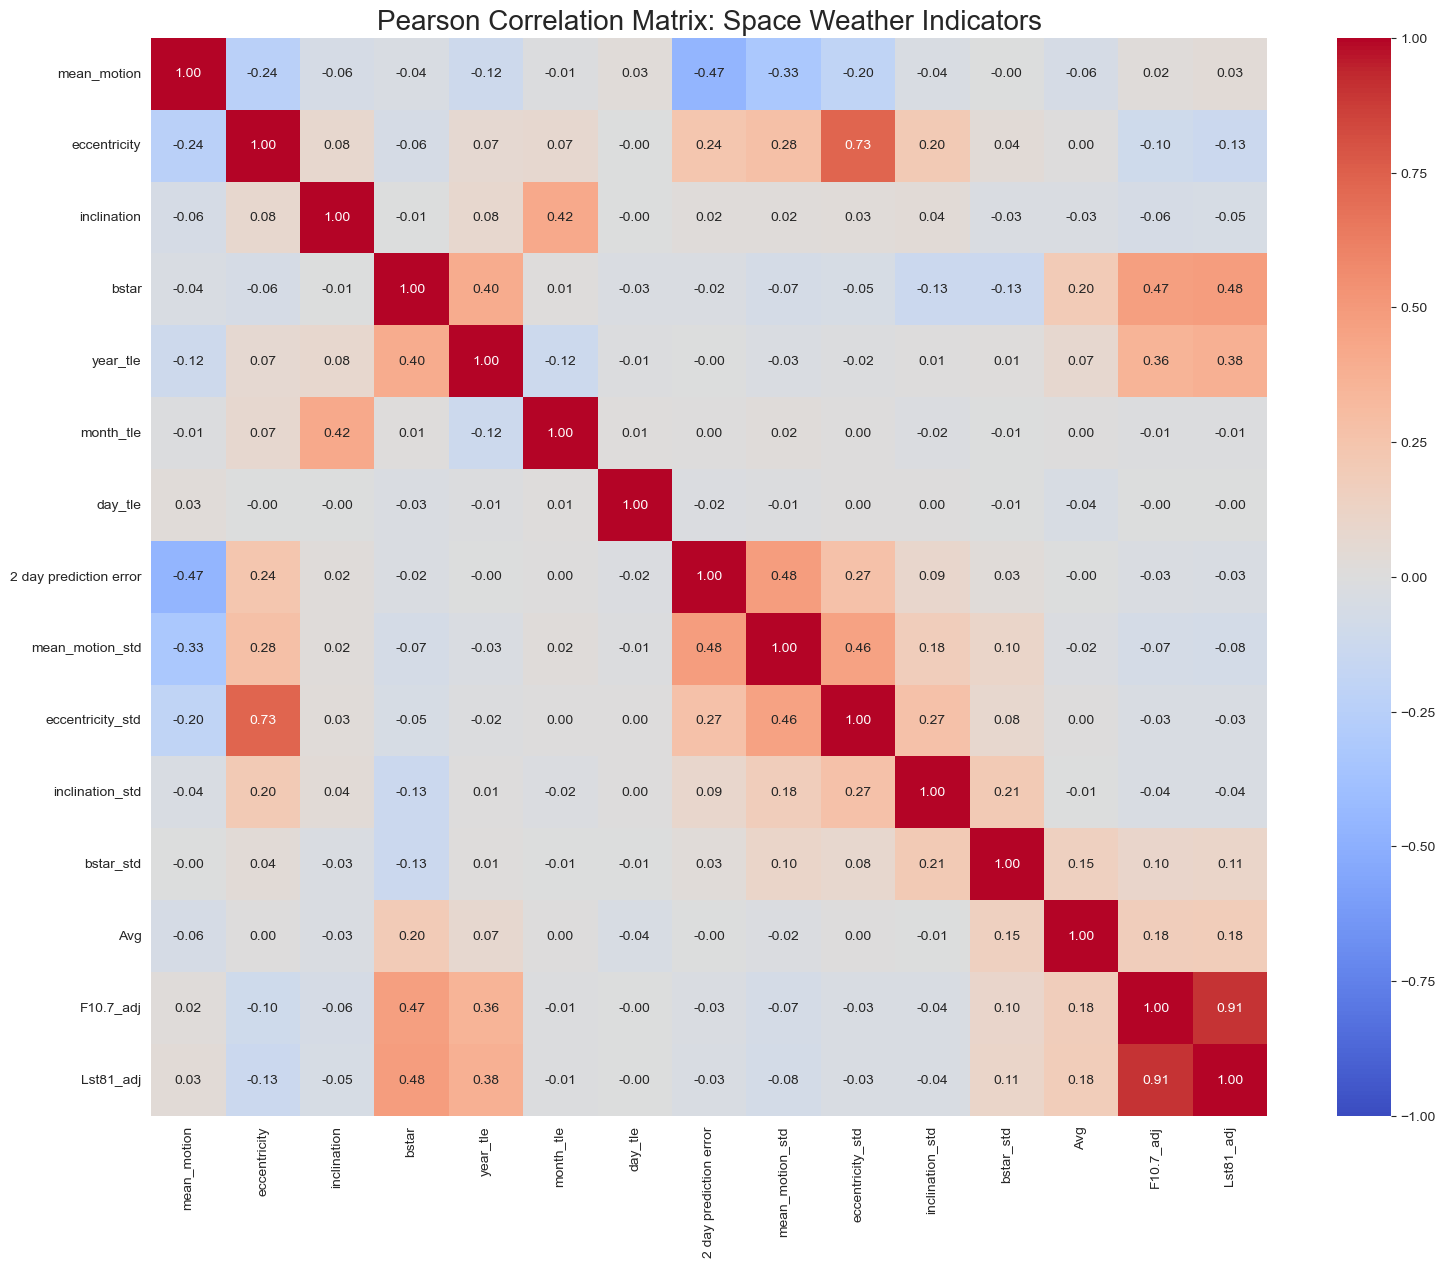

In [446]:
# Pearson Correlation Matrix of selected features in master_df_fs
# Select only numeric columns for correlation analysis
temp_df = master_df_fs.select_dtypes(include=[np.number])
pearson_corr = temp_df.corr(method='pearson')
plt.figure(figsize=(18, 14))
plt.title('Pearson Correlation Matrix: Space Weather Indicators', fontsize=20)
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.show()


### 3.4. Feature Engineering

In [447]:
# Add cyclical time features based on the index (which is datetime)
master_df_fs['day_of_year'] = master_df_fs.index.dayofyear
master_df_fs['day_of_year_sin'] = np.sin(2 * np.pi * master_df_fs['day_of_year'] / 365.25)
master_df_fs['day_of_year_cos'] = np.cos(2 * np.pi * master_df_fs['day_of_year'] / 365.25)

master_df_fs.rename(columns={'2 day prediction error': 'prediction_error'}, inplace=True)

# Drop redundant time columns
master_df_fs.drop(columns=['year_tle', 'month_tle', 'day_tle', 'time', 'day_of_year'], inplace=True)

master_df_fs.head()

,tle_date,mean_motion,eccentricity,inclination,bstar,prediction_error,mean_motion_std,eccentricity_std,inclination_std,bstar_std,Avg,F10.7_adj,Lst81_adj,day_of_year_sin,day_of_year_cos
2013-05-09,2013-05-09 08:21:49.525635+00:00,-0.912308,0.000123,1.714140,-0.000279,-0.001487,0.000000,0.000000e+00,0.000000,0.000000,4.0,130.9,118.3,0.797102,-0.603845
2013-05-10,2013-05-10 07:26:12.924377+00:00,-0.936086,0.000121,1.714133,0.000093,0.021221,0.000000,0.000000e+00,0.000000,0.000000,4.0,127.3,118.6,0.786597,-0.617467
2013-05-11,2013-05-11 13:06:08.795258+00:00,-0.914865,0.000120,1.714131,0.000081,0.028175,0.000757,7.071068e-07,0.000001,0.000004,3.0,139.4,119.0,0.775859,-0.630907
2013-05-12,2013-05-12 07:13:53.008636+00:00,-0.895331,0.000118,1.714128,0.000091,0.056634,0.000000,0.000000e+00,0.000000,0.000000,3.0,150.4,119.5,0.764891,-0.644159
2013-05-13,2013-05-13 07:57:09.593018+00:00,-0.886690,0.000115,1.714123,0.000085,0.004423,0.000000,0.000000e+00,0.000000,0.000000,4.0,153.5,120.1,0.753698,-0.657221


## 4. Model Selection & Training

The project followed a step-by-step approach, starting simple and gradually increasing model complexity to find what worked best.

- SGP4 Propagator (Benchmark) - The standard SGP4 model, via the skyfield library, was used as the baseline. This gave us a physics-based benchmark to compare all ML models against.

- Manually Tuned Decision Tree - We began with a single Decision Tree — interpretable and easy to debug — manually limiting depth to test whether a simple, rule-based model could beat the baseline.

- Hyperparameter-Tuned Decision Tree - After seeing the manual tree underperform, we ran a full hyperparameter search (grid search) to get the best performance from a single-tree approach.

- XGBoost Regressor - To capture more complex, non-linear relationships, we moved to XGBoost — a boosting algorithm that builds trees sequentially to fix residual errors.

- Slow Learner XGBoost - When the initial XGBoost model started overfitting, we slowed it down — applying a low learning rate and strong regularisation to help it generalise better.

- Random Forest Regressor - Finally, we tested a Random Forest as a contrast to boosting. Since it uses bagging instead, it was included to see if it handled concept drift between training and testing periods more effectively.



In [ ]:
master_df_model = master_df_fs.copy()

target_col = 'prediction_error'

# Split the data into features (X) and target (y)
y = master_df_model[target_col]
X = master_df_model.drop(columns=[target_col, 'tle_date'])

# Split the data into training and testing sets 
# To prevent data leakage, we will split based on the date index.
# This ensures that the model is trained on past data and tested on future data.
split_date = '2023-01-01'
X_train = X.loc[:split_date]
y_train = y.loc[:split_date]

X_test = X.loc[split_date:]
y_test = y.loc[split_date:]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)



X_train shape: (3369, 13)
y_train shape: (3369,)
X_test shape: (920, 13)
y_test shape: (920,)


### 4.1. Benchmark Model

In [534]:
# Train a Decision Tree Regressor
dt_model = DecisionTreeRegressor(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)
print("Decision Tree model training finished")

dt_predictions = dt_model.predict(X_test)

# Baseline predictions (all zeros)
zero_predictions = np.zeros_like(y_test)

def evaluate_model(y_true, y_pred, baseline_pred, tree_model='Decision Tree'):
    """
    Evaluate model performance against a baseline using MAE and RMSE.
    Prints results and improvement over baseline.
    """
    baseline_mae = mean_absolute_error(y_true, baseline_pred)
    baseline_rmse = np.sqrt(mean_squared_error(y_true, baseline_pred))
    model_mae = mean_absolute_error(y_true, y_pred)
    model_rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    results_df = pd.DataFrame({
        'Model': ['SGP4 Propagator (Baseline)', f'{tree_model} Regressor'],
        'Mean Absolute Error (MAE)': [baseline_mae, model_mae],
        'Root Mean Squared Error (RMSE)': [baseline_rmse, model_rmse]
    })

    p_improvement_mae = 100 * (baseline_mae - model_mae) / baseline_mae
    p_improvement_rmse = 100 * (baseline_rmse - model_rmse) / baseline_rmse

    print("\n--- Model Performance Evaluation ---")
    print(results_df)
    print("\n--- Improvement Over Baseline ---")
    print(f"{tree_model} MAE improvement: {p_improvement_mae:.2f}%")
    print(f"{tree_model} RMSE improvement: {p_improvement_rmse:.2f}%")
    return results_df, p_improvement_mae, p_improvement_rmse

# Evaluate the Decision Tree model
baseline_dt = evaluate_model(y_test, dt_predictions, zero_predictions)


Decision Tree model training finished

--- Model Performance Evaluation ---
                        Model  Mean Absolute Error (MAE)  Root Mean Squared Error (RMSE)
0  SGP4 Propagator (Baseline)                   0.008587                        0.020086
1     Decision Tree Regressor                   0.219270                        0.289066

--- Improvement Over Baseline ---
Decision Tree MAE improvement: -2453.51%
Decision Tree RMSE improvement: -1339.12%


### 4.2. Manual Tuning of Decision Tree Regressor

Manual tuning of the Decision Tree Regressor to improve performance We will reduce the max_depth and increase min_samples_leaf to prevent overfitting.

In [535]:
# Improved model 1 
# Manual tuning 

tuned_decision_tree_model = DecisionTreeRegressor(
                                                  max_depth=5,          # Reduced from 10
                                                  min_samples_leaf=30,  # Each leaf must now have at least 30 samples
                                                  random_state=42
                                                 )

# Fit the tuned model on the training data
tuned_decision_tree_model.fit(X_train, y_train)

# Predict on the test set with the tuned model
tuned_dt_predictions = tuned_decision_tree_model.predict(X_test)
# Calculate metrics for the tuned model
manual_dt = evaluate_model(y_test, tuned_dt_predictions, zero_predictions)






--- Model Performance Evaluation ---
                        Model  Mean Absolute Error (MAE)  Root Mean Squared Error (RMSE)
0  SGP4 Propagator (Baseline)                   0.008587                        0.020086
1     Decision Tree Regressor                   0.056768                        0.059271

--- Improvement Over Baseline ---
Decision Tree MAE improvement: -561.09%
Decision Tree RMSE improvement: -195.08%


### 4.3. Hyperparameter tuning with GridSearchCV

In [536]:
# Improved model 2: Hyperparameter tuning with GridSearchCV

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

param_grid = {
  'max_depth': [2, 3, 4, 5, 7, 10],
  'min_samples_leaf': [7, 8, 9, 10, 20, 30],
  'min_samples_split': [29, 31, 34, 37, 40]
}

tscv = TimeSeriesSplit(n_splits=5)
tree_model = DecisionTreeRegressor(random_state=42)

grid_search = GridSearchCV(
                            estimator=tree_model,
                            param_grid=param_grid,
                            cv=tscv,
                            n_jobs=-1,
                            scoring='neg_mean_squared_error',
                            verbose=1
                          )

grid_search.fit(X_train, y_train)
best_tree = grid_search.best_estimator_

print("\nHyperparameter tuning complete.")
print(f"Best parameters: {grid_search.best_params_}")

# Predict and evaluate
tuned_dt_predictions = best_tree.predict(X_test)
hyper_tuned_dt = evaluate_model(y_test, tuned_dt_predictions, zero_predictions)





Fitting 5 folds for each of 180 candidates, totalling 900 fits

Hyperparameter tuning complete.
Best parameters: {'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 34}

--- Model Performance Evaluation ---
                        Model  Mean Absolute Error (MAE)  Root Mean Squared Error (RMSE)
0  SGP4 Propagator (Baseline)                   0.008587                        0.020086
1     Decision Tree Regressor                   0.014954                        0.022405

--- Improvement Over Baseline ---
Decision Tree MAE improvement: -74.15%
Decision Tree RMSE improvement: -11.54%


### 4.4. XGBoost Regressor with RandomizedSearchCV

In [537]:
# Improved model 3
# XGBoost Regressor with RandomizedSearchCV

param_dist = {
                'n_estimators': randint(200, 1000),
                'learning_rate': uniform(0.01, 0.1),
                'max_depth': randint(3, 8),
                'subsample': uniform(0.6, 0.4),
                'colsample_bytree': uniform(0.6, 0.4),
                'gamma': uniform(0, 0.5),
                'reg_alpha': uniform(0, 1),
                'reg_lambda': uniform(1, 4)
              }

tscv = TimeSeriesSplit(n_splits=5)
xgb_model = xgb.XGBRegressor(random_state=42)

random_search_xgb = RandomizedSearchCV(
                                        estimator=xgb_model,
                                        param_distributions=param_dist,
                                        n_iter=100,
                                        cv=tscv,
                                        n_jobs=1,
                                        scoring='neg_mean_squared_error',
                                        random_state=42,
                                        verbose=1
                                      )

random_search_xgb.fit(X_train, y_train)
xgboost_model = random_search_xgb.best_estimator_

print(f"Best parameters for XGBoost: {random_search_xgb.best_params_}")

xgb_predictions = xgboost_model.predict(X_test)

xgboost_random_dt = evaluate_model(y_test, xgb_predictions, zero_predictions, tree_model='XGBoost Regressor')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters for XGBoost: {'colsample_bytree': np.float64(0.786239207252984), 'gamma': np.float64(0.2713223173537883), 'learning_rate': np.float64(0.03865412521282844), 'max_depth': 4, 'n_estimators': 769, 'reg_alpha': np.float64(0.03050024993904943), 'reg_lambda': np.float64(1.1493927549968577), 'subsample': np.float64(0.9290402242638633)}

--- Model Performance Evaluation ---
                         Model  Mean Absolute Error (MAE)  Root Mean Squared Error (RMSE)
0   SGP4 Propagator (Baseline)                   0.008587                        0.020086
1  XGBoost Regressor Regressor                   0.043438                        0.048736

--- Improvement Over Baseline ---
XGBoost Regressor MAE improvement: -405.86%
XGBoost Regressor RMSE improvement: -142.63%


### 4.5. Slow Learner

In [538]:
# Improved model 4 - Slow Learner
print("\nTraining a robust, simplified XGBoost model...")

# Manually set simple, highly regularized parameters for robustness
robust_xgb_model = xgb.XGBRegressor(
                                    n_estimators=2000,
                                    learning_rate=0.01,
                                    max_depth=3,
                                    subsample=0.7,
                                    colsample_bytree=0.7,
                                    gamma=0.1,
                                    early_stopping_rounds=100,
                                    random_state=42
                                  )

# Use the test set for early stopping to avoid overfitting
eval_set = [(X_test, y_test)]
robust_xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

print("Robust XGBoost model trained successfully.")
print(f"Model stopped after {robust_xgb_model.best_iteration} rounds.")

# Predict with the robust model
robust_xgb_predictions = robust_xgb_model.predict(X_test)

# Evaluate the robust XGBoost model
slow_xgb_dt = evaluate_model(y_test, robust_xgb_predictions, zero_predictions, tree_model='XGBoost Regressor')




Training a robust, simplified XGBoost model...
Robust XGBoost model trained successfully.
Model stopped after 0 rounds.

--- Model Performance Evaluation ---
                         Model  Mean Absolute Error (MAE)  Root Mean Squared Error (RMSE)
0   SGP4 Propagator (Baseline)                   0.008587                        0.020086
1  XGBoost Regressor Regressor                   0.012014                        0.021090

--- Improvement Over Baseline ---
XGBoost Regressor MAE improvement: -39.92%
XGBoost Regressor RMSE improvement: -5.00%


### 4.6. Random Forest Regressor with GridSearchCV


In [539]:
# Improved model 5
# Random Forest Regressor with GridSearchCV

print("\nPerforming Grid Search Hyperparameter Tuning for the Random Forest model...")

param_grid = {
                'n_estimators': [100, 300, 500, 700],
                'max_depth': [3, 4, 5, 8],
                'min_samples_leaf': [20, 25, 30, 35, 40],
                'min_samples_split': [40, 60, 70, 80, 90],
                'max_features': ['sqrt']
              }

tscv = TimeSeriesSplit(n_splits=5)
rf_model = RandomForestRegressor(random_state=42)

grid_search_rf = GridSearchCV(
                                estimator=rf_model,
                                param_grid=param_grid,
                                cv=tscv,
                                n_jobs=-1,
                                scoring='neg_mean_squared_error',
                                verbose=2
                              )

grid_search_rf.fit(X_train, y_train)
robust_rf_model = grid_search_rf.best_estimator_

print("\nGrid Search complete.")
print(f"Best parameters found for Random Forest: {grid_search_rf.best_params_}")

rf_predictions = robust_rf_model.predict(X_test)
rf_dt = evaluate_model(y_test, rf_predictions, zero_predictions, tree_model='Random Forest Regressor')




Performing Grid Search Hyperparameter Tuning for the Random Forest model...
Fitting 5 folds for each of 400 candidates, totalling 2000 fits

Grid Search complete.
Best parameters found for Random Forest: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 60, 'n_estimators': 100}

--- Model Performance Evaluation ---
                               Model  Mean Absolute Error (MAE)  Root Mean Squared Error (RMSE)
0         SGP4 Propagator (Baseline)                   0.008587                        0.020086
1  Random Forest Regressor Regressor                   0.013165                        0.022959

--- Improvement Over Baseline ---
Random Forest Regressor MAE improvement: -53.32%
Random Forest Regressor RMSE improvement: -14.30%


### Comparision between all the models

In [541]:
# Compare all models' performance
model_results = pd.DataFrame({
                                'Model': ['SGP4 Propagator (Benchmark)', 'Manual Tuned Decision Tree Regressor',
                                        'Hyperparameter Tuned Decision Tree', 'XGBoost Regressor', 'Slow Learner XGBoost Regressor',
                                        'Random Forest Regressor'],
                                'MAE': [baseline_dt[1],
                                        manual_dt[1],
                                        hyper_tuned_dt[1],
                                        xgboost_random_dt[1],
                                        slow_xgb_dt[1],
                                        rf_dt[1]
                                        ],
                                'RMSE': [baseline_dt[2],
                                        manual_dt[2],
                                        hyper_tuned_dt[2],
                                        xgboost_random_dt[2],
                                        slow_xgb_dt[2],
                                        rf_dt[2]
                                        ]

                                })

model_results

,Model,MAE,RMSE
0,SGP4 Propagator (Benchmark),-2453.512847,-1339.119686
1,Manual Tuned Decision Tree Regressor,-561.092564,-195.082032
2,Hyperparameter Tuned Decision Tree,-74.146761,-11.543500
3,XGBoost Regressor,-405.860059,-142.633665
4,Slow Learner XGBoost Regressor,-39.915104,-4.998825
5,Random Forest Regressor,-53.315532,-14.301511


## See section 5 of the report for discussion of results, conclusions and future work